In [1]:
from __future__ import print_function

# standard libraries
import os
import math

from functools import partial

# numpy library
import numpy as np

# matplotlib libraries
import matplotlib.pyplot as plt

# pandas library
import pandas
import pandas as pd

# sci-kit learn libraries
import sklearn

from sklearn.linear_model import (LinearRegression, Lars,
                                  BayesianRidge, Lasso, Ridge, ElasticNet,
                                  RidgeCV, LassoCV, ElasticNetCV, LarsCV,
                                  LassoLarsIC
                                  )

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import (KFold, GridSearchCV, 
                                     train_test_split, learning_curve)

from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler,
                                   LabelEncoder, OneHotEncoder)

from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error, make_scorer

from xgboost import XGBRegressor

from skrebate import ReliefF, SURF, SURFstar, MultiSURF, MultiSURFstar, TuRF
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

# feature selection libraries
from feature_selector import FeatureSelector
import pymrmr

# model interpretation library
import shap

from collections import OrderedDict

d:\software\miniconda\envs\bike\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Fix random seed for reproducibility
seed = 42
np.random.seed(seed)
verbose   = 2

In [3]:
# Extract estimator name
def extract_estimator_name(estimator):

    # check to see if estimator is a pipeline object or not
    if isinstance(estimator, sklearn.pipeline.Pipeline):
        data_type = type(estimator._final_estimator)

    # check to see if estimator is a grid search object or not
    elif isinstance(estimator, sklearn.model_selection._search.GridSearchCV):
        # check to see if estimator is a pipeline object or not
        if isinstance(estimator.best_estimator_, sklearn.pipeline.Pipeline):
            data_type = type(estimator.best_estimator_._final_estimator)

        else:
            data_type = type(estimator.best_estimator_)

    # object is not a pipeline or grid search estimator
    else:
        data_type = type(estimator)

    name = ''.join(filter(str.isalnum, str(data_type).split('.')[-1]))

    return name

# Standard nested k-fold cross validation
def grid_search(estimator, X, y, outer_cv, inner_cv,
                param_grid, scoring='accuracy',
                n_jobs=1, debug=False):
    """
    Nested k-fold cross-validation

    Parameters
    ----------
    estimator : array, shape = [n_samples]
         true class, integers in [0, n_classes - 1)
    X : array,   shape = [n_samples, n_classes]
    y : array,   shape = [n_samples, n_classes]
    outer_cv :   shape = [n_samples, n_classes]
    inner_cv :   shape = [n_samples, n_classes]
    param_grid : shape = [n_samples, n_classes]
    scoring :    shape = [n_samples, n_classes]
    n_jobs : int, default 1
    debug : boolean, default Fasle

    Returns
    -------
    grid : GridSearchCV object
        A post-fit (re-fitted to full dataset) GridSearchCV 
        object where the estimator is a Pipeline.
    """

    outer_scores = []

    # Extract model name
    name = extract_estimator_name(estimator)

    # Set up grid search configuration
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid,
                        cv=inner_cv, scoring=scoring, n_jobs=n_jobs)

    # Set aside a hold-out test data for model evaluation
    for k, (training_samples, test_samples) in enumerate(outer_cv.split(X, y)):

        # x training and test data
        if isinstance(X, pd.DataFrame):
            x_train = X.iloc[training_samples]
            x_test = X.iloc[test_samples]

        # in case of spare matrices
        else:
            x_train = X[training_samples]
            x_test = X[test_samples]

        # y training and test data
        if isinstance(y, pd.Series):
            y_train = y.iloc[training_samples]
            y_test = y.iloc[test_samples]

        # in case of numpy arrays
        else:
            y_train = y[training_samples]
            y_test = y[test_samples]

        # Build classifier on best parameters using outer training set
        # Fit model to entire training data (i.e tuning & validation dataset)
        print('fold-', k+1, 'model fitting...')

        # Train on the training set
        grid.fit(x_train, y_train)

        # Hyper-parameters of the best model
        if debug:
            print('\n\t', grid.best_estimator_.get_params()[name])

        # Evaluate
        score = grid.score(x_test, y_test)

        outer_scores.append(abs(score))
        print('\n\tModel validation score:', abs(score), '\n')

    # Print hyper-parameters of best model
    print('\nHyper-paramters of best model:\n\n',
          grid.best_estimator_.get_params()[name])

    # Print final model evaluation (i.e. mean cross-validation scores)
    print('\nFinal model evaluation (mean cross-val scores):',
          np.array(outer_scores).mean())

    return grid

# Define learning curve plot
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        scoring=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    scoring : string

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).

    train_sizes : array-like
    """
    
    train_sizes, train_scores, test_scores = learning_curve(
                 estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs,
                 train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Set figure size before plotting
    plt.figure(figsize=(8, 6))
        
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r')
    
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
             label='Training score')
    
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
             label='Cross-validation score')
    
    plt.title(title)
        
    plt.xlabel('Training sample size')
    plt.ylabel('Score: '+scoring)
    
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.legend(loc='best')
    
    return display(plt.show())

# Define error measure for official scoring : RMSE
def rmse_cv(model, X, y, scorer='neg_mean_squared_error'):
    rmse= np.sqrt(-cross_val_score(model, 
                                   X, y, 
                                   scoring=scorer, 
                                   cv = 3))
    return rmse

# functions used for feature engineering
def f_sine(t, T): return math.sin(2*math.pi*t/T)
def f_cosine(t, T): return math.cos(2*math.pi*t/T)

# Load Data


In [4]:
# Load station data
station_data = pd.read_csv(filepath_or_buffer='bikeHub_task/hubway_stations.csv',
                           sep=',', header=0,
                           names=['id','terminal','station','municipal','lat','lng','status'])

# Size of station data
print('dimensions of station data:',station_data.shape)

# Check to see if station data has any missing values
# Note: false means no data is missing
print('check if any data is missing:', 
      station_data.isnull().values.any())

# Print out a few samples from station dataset
station_data.head(5)

dimensions of station data: (142, 7)
check if any data is missing: False


id terminal                             station municipal        lat  \
0   3   B32006              Colleges of the Fenway    Boston  42.340021   
1   4   C32000         Tremont St. at Berkeley St.    Boston  42.345392   
2   5   B32012  Northeastern U / North Parking Lot    Boston  42.341814   
3   6   D32000            Cambridge St. at Joy St.    Boston  42.361285   
4   7   A32000                            Fan Pier    Boston  42.353412   

         lng    status  
0 -71.100812  Existing  
1 -71.069616  Existing  
2 -71.090179  Existing  
3 -71.065140  Existing  
4 -71.044624  Existing

In [5]:
# Load trip data
trip_data = pd.read_csv(filepath_or_buffer='bikeHub_task/hubway_trips.csv',
                           sep=',', header=0, infer_datetime_format=True, dayfirst=True,
                           parse_dates=['start_date', 'end_date'],
                           names=['seq_id','hubway_id','status','duration','start_date','strt_statn','end_date','end_statn','bike_nr','subsc_type','zip_code','birth_date','gender'])

# Size of station data
print('dimensions of trip data:',trip_data.shape)

# Check to see if station data has any missing values
# Note: false means no data is missing
print('check if any data is missing:', 
      trip_data.isnull().values.any())

# Print out a few samples from station dataset
trip_data.head(5)

dimensions of trip data: (1579025, 13)
check if any data is missing: True


seq_id  hubway_id  status  duration          start_date  strt_statn  \
0       1          8  Closed         9 2011-07-28 10:12:00        23.0   
1       2          9  Closed       220 2011-07-28 10:21:00        23.0   
2       3         10  Closed        56 2011-07-28 10:33:00        23.0   
3       4         11  Closed        64 2011-07-28 10:35:00        23.0   
4       5         12  Closed        12 2011-07-28 10:37:00        23.0   

             end_date  end_statn bike_nr  subsc_type zip_code  birth_date  \
0 2011-07-28 10:12:00       23.0  B00468  Registered   '97217      1976.0   
1 2011-07-28 10:25:00       23.0  B00554  Registered   '02215      1966.0   
2 2011-07-28 10:34:00       23.0  B00456  Registered   '02108      1943.0   
3 2011-07-28 10:36:00       23.0  B00554  Registered   '02116      1981.0   
4 2011-07-28 10:37:00       23.0  B00554  Registered   '97214      1983.0   

   gender  
0    Male  
1    Male  
2    Male  
3  Female  
4  Female

In [6]:
# Load weather data
weather_data = pd.read_csv(filepath_or_buffer='bikeHub_task/weather.csv',
                           sep=',', infer_datetime_format=True, 
                           dayfirst=True,
                           parse_dates=['DATE'])

# Size of trip data
print('dimension of weather data:', weather_data.shape)

# Check to see if weather data has any missing values
# Note: false means no data is missing
print('check if any data is missing:', weather_data.isnull().values.any())

# Print out a few samples from weather dataset
weather_data.head(5)

dimension of weather data: (2654, 9)
check if any data is missing: False


STATION  STATION_NAME  ELEVATION  LATITUDE  LONGITUDE  \
0  COOP:190770  BOSTON MA US        3.7   42.3606   -71.0106   
1  COOP:190770  BOSTON MA US        3.7   42.3606   -71.0106   
2  COOP:190770  BOSTON MA US        3.7   42.3606   -71.0106   
3  COOP:190770  BOSTON MA US        3.7   42.3606   -71.0106   
4  COOP:190770  BOSTON MA US        3.7   42.3606   -71.0106   

                 DATE  HPCP Measurement_Flag Quality_Flag  
0 2011-07-29 09:00:00  0.00                T               
1 2011-07-29 10:00:00  0.00                T               
2 2011-07-29 18:00:00  0.00                T               
3 2011-07-29 21:00:00  0.03                                
4 2011-07-29 22:00:00  0.04

# Data Cleaning

In [7]:
# check the na
trip_data.isna().sum()

seq_id              0
hubway_id           0
status              0
duration            0
start_date          0
strt_statn         14
end_date            0
end_statn          45
bike_nr           466
subsc_type          0
zip_code       472766
birth_date    1228381
gender         472611
dtype: int64

In [8]:
# drop rows with missing values in trip data
trip_data = trip_data.dropna(subset=["strt_statn", "end_statn", "bike_nr"])

In [9]:
# replace missing values in weather data
trip_data['gender'] = trip_data['gender'].fillna('Unknown')
trip_data['birth_date'] = trip_data['birth_date'].fillna(round(trip_data['birth_date'].mean()))
trip_data['zip_code'] = trip_data['zip_code'].fillna('Unknown')

In [10]:
trip_data.isna().sum()

seq_id        0
hubway_id     0
status        0
duration      0
start_date    0
strt_statn    0
end_date      0
end_statn     0
bike_nr       0
subsc_type    0
zip_code      0
birth_date    0
gender        0
dtype: int64

# Data Transformations

In [11]:
# set DATE as index
weather_data_resample = weather_data.set_index(['DATE']).sort_index()

In [12]:
# strt_statn and end_statn are int type
trip_data['strt_statn'] = trip_data['strt_statn'].astype(int)
trip_data['end_statn'] = trip_data['end_statn'].astype(int)
trip_data['birth_date'] = trip_data['birth_date'].astype(int)
# get the round hour of start_date and end_date
trip_data['end_date_round'] = trip_data['end_date'].dt.round('H')
trip_data['start_date_round'] = trip_data['start_date'].dt.round('H')
# get the hour of DATE
trip_data['Hour'] = trip_data['start_date'].dt.hour
trip_data['Day_of_week'] = trip_data['start_date'].apply(lambda dt: dt.weekday())
# Determine if day is weekday or weekend
trip_data['Is_weekday'] = trip_data['Day_of_week']\
        .apply(lambda s: 0 if s in [5, 6] else 1)
# Establish season: winter (0), spring (1), summer (2), fall (3)
trip_data['Season'] = trip_data['start_date'].apply(lambda dt: (dt.month%12 + 3)//3-1)

In [13]:
# Get the map of New station IDs for changed station IDs
map_to_old_id = {}
station_removed = station_data[station_data['status'] == 'Removed']
for index, row in station_removed.iterrows():
    terminal = row['terminal']
    id = row['id']
    station_new = station_data[(station_data['terminal'] == terminal) & (station_data['status'] == 'Existing')]
    if len(station_new) > 0:
        map_to_old_id[station_new['id'].values[0]] = id
print(map_to_old_id)

{102: 13, 99: 23, 112: 35, 110: 37, 111: 38, 100: 56, 113: 60, 103: 61, 126: 82, 104: 85, 129: 97}


In [14]:
# Map new station IDs to old station IDs
station_data['id'].replace(to_replace=map_to_old_id, inplace=True)
trip_data['strt_statn'].replace(to_replace=map_to_old_id, inplace=True)
trip_data['end_statn'].replace(to_replace=map_to_old_id, inplace=True)
# Drop duplicate rows that are produced as a result of mapping new station ID to old station ID
station_data.drop_duplicates(inplace=True)
# Filter the trip in 24 hour
trip_data = trip_data[trip_data['duration'] < 90 * 60]

# Data Aggregation


In [15]:
# Filter the trip data to keep only the trips in Boston
station_data_boston = station_data[(station_data['municipal'] == 'Boston') & (station_data['status'] == 'Existing')]
trip_data_boston = trip_data[trip_data['strt_statn'].isin(station_data_boston['id'].values)]
trip_data_boston = trip_data_boston[trip_data_boston['end_statn'].isin(station_data_boston['id'].values)]

In [16]:
# Filter the trip data to keep only the trips have weather data
trip_data_boston_wether = trip_data_boston[trip_data_boston['end_date_round'].isin(weather_data['DATE'])]

In [17]:
# join the weather data according to the end date
def get_weather_feature(row):
    end_date = row['end_date_round']
    if end_date in weather_data_resample.index:
        weather_info = weather_data_resample.loc[end_date]
        row['HPCP'] = weather_info['HPCP']
        row['Measurement_Flag'] = weather_info['Measurement_Flag']
    return row
trip_data_boston_wether = trip_data_boston_wether.apply(get_weather_feature, axis=1)
trip_data_boston_wether

seq_id  hubway_id  status  duration          start_date  strt_statn  \
477          478        536  Closed      2235 2011-07-29 08:04:00          44   
482          483        541  Closed      1292 2011-07-29 08:17:00          16   
483          484        542  Closed       712 2011-07-29 08:20:00          36   
484          485        543  Closed      1143 2011-07-29 08:19:00          16   
485          486        544  Closed      1421 2011-07-29 08:19:00          43   
488          489        547  Closed       734 2011-07-29 08:24:00          47   
490          491        549  Closed       556 2011-07-29 08:27:00          25   
491          492        550  Closed       687 2011-07-29 08:31:00          33   
492          493        551  Closed       474 2011-07-29 08:32:00          23   
493          494        552  Closed       451 2011-07-29 08:33:00          42   
494          495        553  Closed       718 2011-07-29 08:33:00          40   
495          496        554  Closed       586 2011-07-29 08:33:00          38   
496          497        555  Closed       682 2011-07-29 08:35:00          39   
497          498        556  Closed      1085 2011-07-29 08:36:00          23   
498          499        557  Closed       524 2011-07-29 08:38:00          21   
499          500        558  Closed       407 2011-07-29 08:39:00          22   
500          501        559  Closed      1207 2011-07-29 08:39:00          46   
501          502        560  Closed       336 2011-07-29 08:40:00          38   
502          503        561  Closed      1249 2011-07-29 08:41:00          33   
503          504        562  Closed      1262 2011-07-29 08:41:00          33   
504          505        563  Closed       728 2011-07-29 08:44:00          27   
505          506        564  Closed      1087 2011-07-29 08:46:00          25   
506          507        565  Closed      1903 2011-07-29 08:52:00           9   
507          508        566  Closed       920 2011-07-29 08:52:00          40   
508          509        568  Closed       742 2011-07-29 08:54:00          38   
509          510        569  Closed       692 2011-07-29 08:55:00          38   
510          511        570  Closed       931 2011-07-29 08:55:00          22   
512          513        572  Closed       238 2011-07-29 08:57:00          16   
513          514        573  Closed       545 2011-07-29 09:01:00          38   
515          516        575  Closed       399 2011-07-29 09:10:00          45   
...          ...        ...     ...       ...                 ...         ...   
1042961  1042962    1175766  Closed       420 2013-07-23 19:07:00          45   
1042963  1042964    1175768  Closed       300 2013-07-23 19:07:00          98   
1042967  1042968    1175772  Closed       660 2013-07-23 19:07:00          13   
1042968  1042969    1175773  Closed       240 2013-07-23 19:07:00          16   
1042970  1042971    1175775  Closed       240 2013-07-23 19:08:00          44   
1042974  1042975    1175779  Closed       180 2013-07-23 19:09:00          13   
1042975  1042976    1175780  Closed       180 2013-07-23 19:09:00          42   
1042978  1042979    1175783  Closed       420 2013-07-23 19:09:00          43   
1042983  1042984    1175789  Closed      1020 2013-07-23 19:12:00          27   
1042985  1042986    1175791  Closed       720 2013-07-23 19:13:00           4   
1042989  1042990    1175795  Closed       300 2013-07-23 19:13:00          81   
1042990  1042991    1175796  Closed       300 2013-07-23 19:14:00         114   
1042993  1042994    1175801  Closed       360 2013-07-23 19:15:00           6   
1042996  1042997    1175804  Closed       300 2013-07-23 19:16:00           9   
1042997  1042998    1175805  Closed       540 2013-07-23 19:16:00          23   
1042998  1042999    1175806  Closed       480 2013-07-23 19:17:00          33   
1043002  1043003    1175810  Closed       360 2013-07-23 19:17:00          22   
1043003  1043004    1175811  Closed      

In [18]:
# join the trip with station
df_final = trip_data_boston_wether.merge(station_data_boston, left_on='strt_statn', right_on='id', how='left')

# Data Exploration
Now that we have the data at our disposal we can explore it to find any trends or features that may help us better model our problem. We view the statistical info of duration in all trips.

In [19]:
# duration info
df_final['duration'].describe()

count    66381.000000
mean       735.364442
std        666.063054
min          0.000000
25%        356.000000
50%        540.000000
75%        900.000000
max       5392.000000
Name: duration, dtype: float64

<AxesSubplot:>

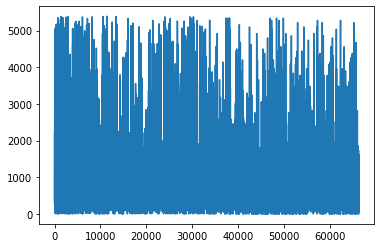

In [20]:
df_final['duration'].plot()

<AxesSubplot:>

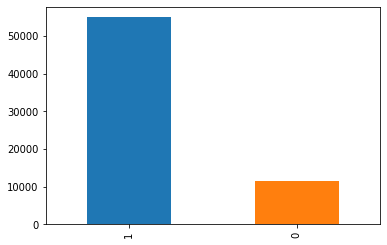

In [21]:
df_final['Is_weekday'].value_counts().plot(kind='bar')

<AxesSubplot:>

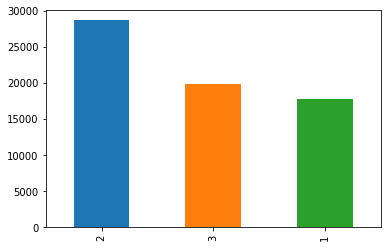

In [22]:
df_final['Season'].value_counts().plot(kind='bar')

<AxesSubplot:>

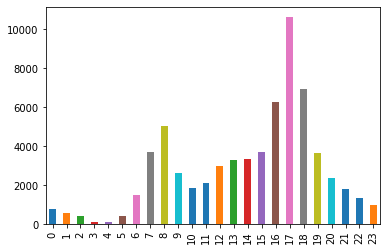

In [23]:
df_final['Hour'].value_counts().sort_index().plot(kind='bar')

<AxesSubplot:>

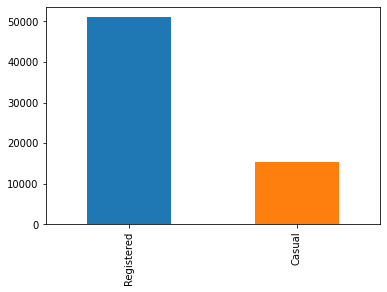

In [24]:
df_final['subsc_type'].value_counts().plot(kind='bar')

count    66381.000000
mean      1976.136048
std          6.826815
min       1939.000000
25%       1976.000000
50%       1976.000000
75%       1976.000000
max       1995.000000
Name: birth_date, dtype: float64


<AxesSubplot:>

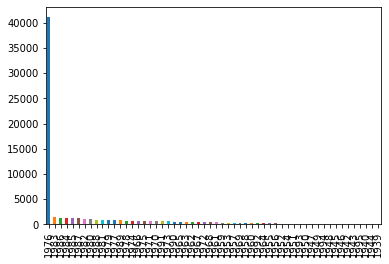

In [25]:
print(df_final['birth_date'].describe())
df_final['birth_date'].value_counts().plot(kind='bar')

<AxesSubplot:>

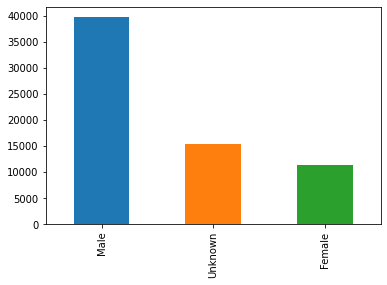

In [26]:
df_final['gender'].value_counts().plot(kind='bar')

<AxesSubplot:>

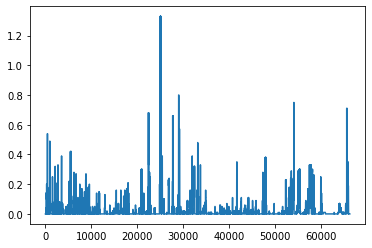

In [27]:
df_final['HPCP'].plot()

<AxesSubplot:>

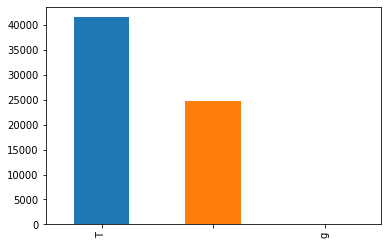

In [28]:
df_final['Measurement_Flag'].value_counts().plot(kind='bar')

<AxesSubplot:xlabel='lat', ylabel='lng'>

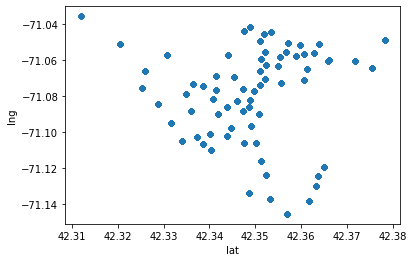

In [29]:
df_final.plot(kind='scatter', x='lat', y='lng')

In [30]:
num_features = ['Hour', 'birth_date','HPCP','lat','lng','Season', 'Day_of_week', 'duration']
cat_features = ['strt_statn','subsc_type','gender','Measurement_Flag']
df_final['strt_statn'] = df_final['strt_statn'].astype(str)
df_feature = df_final[num_features + cat_features]
df_feature

Hour  birth_date  HPCP        lat        lng  Season  Day_of_week  \
0         8        1976   0.0  42.360583 -71.056868       2            4   
1         8        1976   0.0  42.347433 -71.076163       2            4   
2         8        1976   0.0  42.349673 -71.077303       2            4   
3         8        1976   0.0  42.347433 -71.076163       2            4   
4         8        1966   0.0  42.357143 -71.050699       2            4   
5         8        1976   0.0  42.362811 -71.056067       2            4   
6         8        1971   0.0  42.341332 -71.076847       2            4   
7         8        1976   0.0  42.349046 -71.096831       2            4   
8         8        1976   0.0  42.358920 -71.057629       2            4   
9         8        1976   0.0  42.352096 -71.070378       2            4   
10        8        1959   0.0  42.363871 -71.050877       2            4   
11        8        1968   0.0  42.366222 -71.059914       2            4   
12        8        1976   0.0  42.338623 -71.074182       2            4   
13        8        1986   0.0  42.358920 -71.057629       2            4   
14        8        1979   0.0  42.345959 -71.082578       2            4   
15        8        1966   0.0  42.352175 -71.055547       2            4   
16        8        1976   0.0  42.343864 -71.085918       2            4   
17        8        1963   0.0  42.366222 -71.059914       2            4   
18        8        1980   0.0  42.349046 -71.096831       2            4   
19        8        1981   0.0  42.349046 -71.096831       2            4   
20        8        1984   0.0  42.331567 -71.094734       2            4   
21        8        1976   0.0  42.341332 -71.076847       2            4   
22        8        1976   0.0  42.351313 -71.116174       2            4   
23        8        1976   0.0  42.363871 -71.050877       2            4   
24        8        1950   0.0  42.366222 -71.059914       2            4   
25        8        1976   0.0  42.366222 -71.059914       2            4   
26        8        1962   0.0  42.352175 -71.055547       2            4   
27        8        1973   0.0  42.347433 -71.076163       2            4   
28        9        1950   0.0  42.366222 -71.059914       2            4   
29        9        1974   0.0  42.344763 -71.097880       2            4   
...     ...         ...   ...        ...        ...     ...          ...   
66351    19        1976   0.0  42.344763 -71.097880       2            1   
66352    19        1976   0.0  42.371848 -71.060292       2            1   
66353    19        1976   0.0  42.336437 -71.073089       2            1   
66354    19        1976   0.0  42.347433 -71.076163       2            1   
66355    19        1976   0.0  42.360583 -71.056868       2            1   
66356    19        1976   0.0  42.336437 -71.073089       2            1   
66357    19        1976   0.0  42.352096 -71.070378       2            1   
66358    19        1976   0.0  42.357143 -71.050699       2            1   
66359    19        1976   0.0  42.331567 -71.094734       2            1   
66360    19        1976   0.0  42.345392 -71.069616       2            1   
66361    19        1976   0.0  42.352409 -71.062679       2            1   
66362    19        1976   0.0  42.365942 -71.060515       2            1   
66363    19        1976   0.0  42.361285 -71.065140       2            1   
66364    19        1976   0.0  42.351313 -71.116174       2            1   
66365    19        1976   0.0  42.358920 -71.057629       2            1   
66366    19        1976   0.0  42.349046 -71.096831       2            1   
66367    19        1976   0.0  42.352175 -71.055547       2            1   
66368    19        1976   0.0  42.348762 -71.082383       2            1   
66369    19        1976   0.0  42.371848 -71.060292       2            1   
66370    19        1976   0.0  42.349673 -71.077303       2            1   
66371    19        1976   0.0  42.378338 -71.048927    

In [31]:
# Convert Hour to cyclic value
partial_sine = partial(f_sine, T=23)
partial_cosine = partial(f_cosine, T=23)

df_feature['Hour_sine'] = df_feature['Hour'].apply(partial_sine)
df_feature['Hour_cosine'] = df_feature['Hour'].apply(partial_cosine)

# Convert Day of week to cyclic value
partial_sine = partial(f_sine, T=6)
partial_cosine = partial(f_cosine, T=6)

df_feature['Day_of_week_sine'] = df_feature['Day_of_week'].apply(partial_sine)
df_feature['Day_of_week_cosine'] = df_feature['Day_of_week'].apply(partial_cosine)

# Convert Season to cyclic value
partial_sine = partial(f_sine, T=3)
partial_cosine = partial(f_cosine, T=3)

df_feature['Season_sine'] = df_feature['Season'].apply(partial_sine)
df_feature['Season_cosine'] = df_feature['Season'].apply(partial_cosine)
df_feature.drop(['Hour', 'Season', 'Day_of_week'], axis=1, inplace=True)
df_feature


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is 

birth_date  HPCP        lat        lng  duration strt_statn  \
0            1976   0.0  42.360583 -71.056868      2235         44   
1            1976   0.0  42.347433 -71.076163      1292         16   
2            1976   0.0  42.349673 -71.077303       712         36   
3            1976   0.0  42.347433 -71.076163      1143         16   
4            1966   0.0  42.357143 -71.050699      1421         43   
5            1976   0.0  42.362811 -71.056067       734         47   
6            1971   0.0  42.341332 -71.076847       556         25   
7            1976   0.0  42.349046 -71.096831       687         33   
8            1976   0.0  42.358920 -71.057629       474         23   
9            1976   0.0  42.352096 -71.070378       451         42   
10           1959   0.0  42.363871 -71.050877       718         40   
11           1968   0.0  42.366222 -71.059914       586         38   
12           1976   0.0  42.338623 -71.074182       682         39   
13           1986   0.0  42.358920 -71.057629      1085         23   
14           1979   0.0  42.345959 -71.082578       524         21   
15           1966   0.0  42.352175 -71.055547       407         22   
16           1976   0.0  42.343864 -71.085918      1207         46   
17           1963   0.0  42.366222 -71.059914       336         38   
18           1980   0.0  42.349046 -71.096831      1249         33   
19           1981   0.0  42.349046 -71.096831      1262         33   
20           1984   0.0  42.331567 -71.094734       728         27   
21           1976   0.0  42.341332 -71.076847      1087         25   
22           1976   0.0  42.351313 -71.116174      1903          9   
23           1976   0.0  42.363871 -71.050877       920         40   
24           1950   0.0  42.366222 -71.059914       742         38   
25           1976   0.0  42.366222 -71.059914       692         38   
26           1962   0.0  42.352175 -71.055547       931         22   
27           1973   0.0  42.347433 -71.076163       238         16   
28           1950   0.0  42.366222 -71.059914       545         38   
29           1974   0.0  42.344763 -71.097880       399         45   
...           ...   ...        ...        ...       ...        ...   
66351        1976   0.0  42.344763 -71.097880       420         45   
66352        1976   0.0  42.371848 -71.060292       300         98   
66353        1976   0.0  42.336437 -71.073089       660         13   
66354        1976   0.0  42.347433 -71.076163       240         16   
66355        1976   0.0  42.360583 -71.056868       240         44   
66356        1976   0.0  42.336437 -71.073089       180         13   
66357        1976   0.0  42.352096 -71.070378       180         42   
66358        1976   0.0  42.357143 -71.050699       420         43   
66359        1976   0.0  42.331567 -71.094734      1020         27   
66360        1976   0.0  42.345392 -71.069616       720          4   
66361        1976   0.0  42.352409 -71.062679       300         81   
66362        1976   0.0  42.365942 -71.060515       300        114   
66363        1976   0.0  42.361285 -71.065140       360          6   
66364        1976   0.0  42.351313 -71.116174       300          9   
66365        1976   0.0  42.358920 -71.057629       540         23   
66366        1976   0.0  42.349046 -71.096831       480         33   
66367        1976   0.0  42.352175 -71.055547       360         22   
66368        1976   0.0  42.348762 -71.082383       480         61   
66369        1976   0.0  42.371848 -71.060292       360         98   
66370        1976   0.0  42.349673 -71.077303       540         36   
66371        1976   0.0  42.378338 -71.048927       600        115   
66372        1976   0.0  42.341522 -71.068922       120         26   
66373        1976   0.0  42.352261 -71.123831       120         41   
66374        1976   0.0  42.340799 -71.081572       360         57   
66375        1976   0.0  42.362811 -71.056067       480         47   
66376        1976

In [32]:
# one-hot coding
df_feature = df_feature.join(pd.get_dummies(df_feature[cat_features]))
df_feature.drop(cat_features, axis=1, inplace=True)
df_feature

birth_date  HPCP        lat        lng  duration  Hour_sine  \
0            1976   0.0  42.360583 -71.056868      2235   0.816970   
1            1976   0.0  42.347433 -71.076163      1292   0.816970   
2            1976   0.0  42.349673 -71.077303       712   0.816970   
3            1976   0.0  42.347433 -71.076163      1143   0.816970   
4            1966   0.0  42.357143 -71.050699      1421   0.816970   
5            1976   0.0  42.362811 -71.056067       734   0.816970   
6            1971   0.0  42.341332 -71.076847       556   0.816970   
7            1976   0.0  42.349046 -71.096831       687   0.816970   
8            1976   0.0  42.358920 -71.057629       474   0.816970   
9            1976   0.0  42.352096 -71.070378       451   0.816970   
10           1959   0.0  42.363871 -71.050877       718   0.816970   
11           1968   0.0  42.366222 -71.059914       586   0.816970   
12           1976   0.0  42.338623 -71.074182       682   0.816970   
13           1986   0.0  42.358920 -71.057629      1085   0.816970   
14           1979   0.0  42.345959 -71.082578       524   0.816970   
15           1966   0.0  42.352175 -71.055547       407   0.816970   
16           1976   0.0  42.343864 -71.085918      1207   0.816970   
17           1963   0.0  42.366222 -71.059914       336   0.816970   
18           1980   0.0  42.349046 -71.096831      1249   0.816970   
19           1981   0.0  42.349046 -71.096831      1262   0.816970   
20           1984   0.0  42.331567 -71.094734       728   0.816970   
21           1976   0.0  42.341332 -71.076847      1087   0.816970   
22           1976   0.0  42.351313 -71.116174      1903   0.816970   
23           1976   0.0  42.363871 -71.050877       920   0.816970   
24           1950   0.0  42.366222 -71.059914       742   0.816970   
25           1976   0.0  42.366222 -71.059914       692   0.816970   
26           1962   0.0  42.352175 -71.055547       931   0.816970   
27           1973   0.0  42.347433 -71.076163       238   0.816970   
28           1950   0.0  42.366222 -71.059914       545   0.631088   
29           1974   0.0  42.344763 -71.097880       399   0.631088   
...           ...   ...        ...        ...       ...        ...   
66351        1976   0.0  42.344763 -71.097880       420  -0.887885   
66352        1976   0.0  42.371848 -71.060292       300  -0.887885   
66353        1976   0.0  42.336437 -71.073089       660  -0.887885   
66354        1976   0.0  42.347433 -71.076163       240  -0.887885   
66355        1976   0.0  42.360583 -71.056868       240  -0.887885   
66356        1976   0.0  42.336437 -71.073089       180  -0.887885   
66357        1976   0.0  42.352096 -71.070378       180  -0.887885   
66358        1976   0.0  42.357143 -71.050699       420  -0.887885   
66359        1976   0.0  42.331567 -71.094734      1020  -0.887885   
66360        1976   0.0  42.345392 -71.069616       720  -0.887885   
66361        1976   0.0  42.352409 -71.062679       300  -0.887885   
66362        1976   0.0  42.365942 -71.060515       300  -0.887885   
66363        1976   0.0  42.361285 -71.065140       360  -0.887885   
66364        1976   0.0  42.351313 -71.116174       300  -0.887885   
66365        1976   0.0  42.358920 -71.057629       540  -0.887885   
66366        1976   0.0  42.349046 -71.096831       480  -0.887885   
66367        1976   0.0  42.352175 -71.055547       360  -0.887885   
66368        1976   0.0  42.348762 -71.082383       480  -0.887885   
66369        1976   0.0  42.371848 -71.060292       360  -0.887885   
66370        1976   0.0  42.349673 -71.077303       540  -0.887885   
66371        1976   0.0  42.378338 -71.048927       600  -0.887885   
66372        1976   0.0  42.341522 -71.068922       120  -0.887885   
66373        1976   0.0  42.352261 -71.123831       120  -0.887885   
66374        1976   0.0  42.340799 -71.081572       360  -0.887885   
66375        1976   0.0  42.362811 -71.056067       480  -0.887885   
66376        1976

In [33]:
# Stratified K-Fold cross-validation
k_fold = 3
outer_kfold_cv = KFold(n_splits=k_fold, random_state=seed, shuffle=True)
inner_kfold_cv = KFold(n_splits=k_fold-1, random_state=seed, shuffle=True)

In [34]:
target = 'duration'
features = list(df_feature.columns.values)
features.remove(target)
features

['birth_date',
 'HPCP',
 'lat',
 'lng',
 'Hour_sine',
 'Hour_cosine',
 'Day_of_week_sine',
 'Day_of_week_cosine',
 'Season_sine',
 'Season_cosine',
 'strt_statn_10',
 'strt_statn_105',
 'strt_statn_11',
 'strt_statn_114',
 'strt_statn_115',
 'strt_statn_12',
 'strt_statn_13',
 'strt_statn_14',
 'strt_statn_15',
 'strt_statn_16',
 'strt_statn_17',
 'strt_statn_18',
 'strt_statn_19',
 'strt_statn_20',
 'strt_statn_21',
 'strt_statn_22',
 'strt_statn_23',
 'strt_statn_24',
 'strt_statn_25',
 'strt_statn_26',
 'strt_statn_27',
 'strt_statn_29',
 'strt_statn_3',
 'strt_statn_30',
 'strt_statn_31',
 'strt_statn_32',
 'strt_statn_33',
 'strt_statn_35',
 'strt_statn_36',
 'strt_statn_37',
 'strt_statn_38',
 'strt_statn_39',
 'strt_statn_4',
 'strt_statn_40',
 'strt_statn_41',
 'strt_statn_42',
 'strt_statn_43',
 'strt_statn_44',
 'strt_statn_45',
 'strt_statn_46',
 'strt_statn_47',
 'strt_statn_48',
 'strt_statn_49',
 'strt_statn_5',
 'strt_statn_50',
 'strt_statn_51',
 'strt_statn_52',
 'strt

In [35]:
# Set data
X = df_feature[features]
y = df_feature[target]

In [36]:
# Split data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=seed)

In [37]:
# summarize split
print('Train data rows = %d, columns = %d' % (X_train.shape[0], X_train.shape[1]))
print('Test data rows = %d, columns = %d' % (X_test.shape[0], X_test.shape[1]))

Train data rows = 53104, columns = 90
Test data rows = 13277, columns = 90


# Feature selection
five methods used to identify features to remove:

- Missing Values
- Single Unique Values
- Collinear Features
- Zero Importance Features
- Low Importance Features

In [38]:
X_train.dtypes

birth_date                 int64
HPCP                     float64
lat                      float64
lng                      float64
Hour_sine                float64
Hour_cosine              float64
Day_of_week_sine         float64
Day_of_week_cosine       float64
Season_sine              float64
Season_cosine            float64
strt_statn_10              uint8
strt_statn_105             uint8
strt_statn_11              uint8
strt_statn_114             uint8
strt_statn_115             uint8
strt_statn_12              uint8
strt_statn_13              uint8
strt_statn_14              uint8
strt_statn_15              uint8
strt_statn_16              uint8
strt_statn_17              uint8
strt_statn_18              uint8
strt_statn_19              uint8
strt_statn_20              uint8
strt_statn_21              uint8
strt_statn_22              uint8
strt_statn_23              uint8
strt_statn_24              uint8
strt_statn_25              uint8
strt_statn_26              uint8
          

In [39]:
# Features are in train and labels are in train_labels
fs = FeatureSelector(data = X_train, labels = y_train)

In [40]:
# Running all Methods at Once
np.bool = np.bool_
fs.identify_all(selection_params = {'missing_threshold': 0.5, 
                                    'correlation_threshold': 0.5, 
                                    'task': 'regression', 
                                    'eval_metric': 'l2',
                                    'cumulative_importance': 0.9,
                                    'importance_type':'split',})

0 features with greater than 0.50 missing values.

0 features with a single unique value.



4 features with a correlation magnitude greater than 0.50.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1828]	valid_0's l2: 304491
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1998]	valid_0's l2: 311218
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1989]	valid_0's l2: 291023
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[2000]	valid_0's l2: 316439
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1999]	valid_0's l2: 294807
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[2000]	valid_0's l2: 302750
Training until validation scores don't improve for 100 rounds.
Did not meet early sto

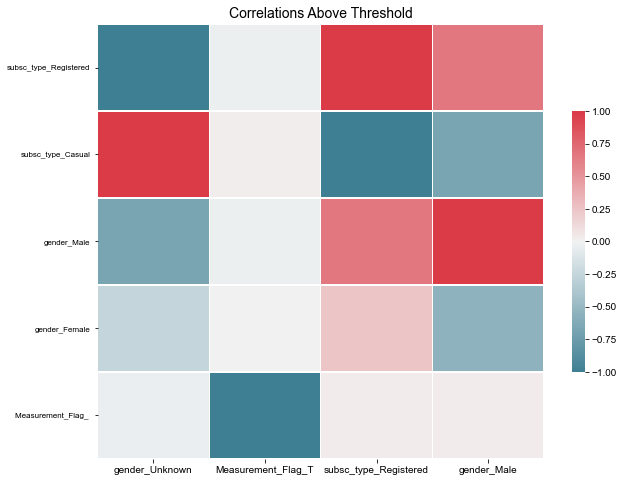

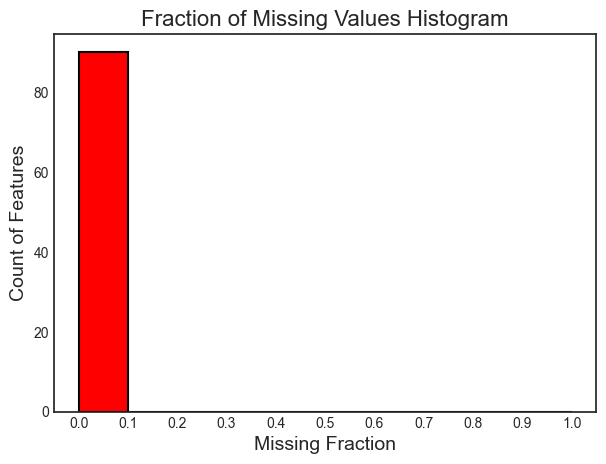

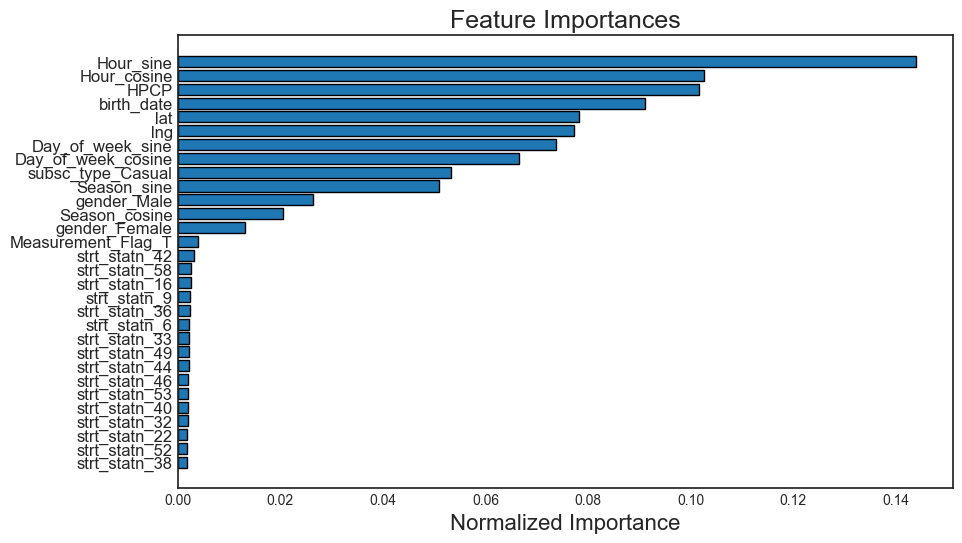

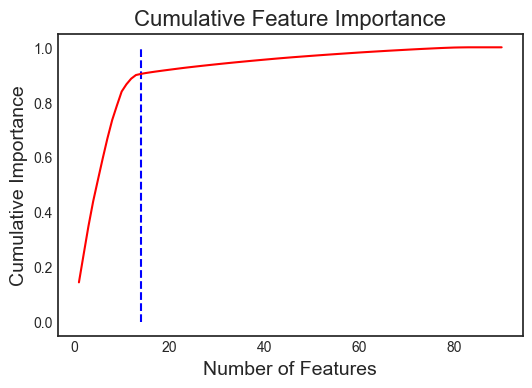

14 features required for 0.90 of cumulative importance


In [41]:
# A neat visualization we can make with correlations is a heatmap. 
# This shows all the features that have at least one correlation above the threshold:
fs.plot_collinear()

# Plot missing Values
fs.plot_missing()

# plot the feature importances
fs.plot_feature_importances(threshold = 0.90, plot_n = 30)

In [42]:
fs.data_all.head()

birth_date  HPCP        lat        lng  Hour_sine  Hour_cosine  \
49779        1976  0.01  42.340021 -71.100812  -0.979084     0.203456   
45822        1976  0.00  42.341332 -71.076847  -0.269797     0.962917   
41441        1976  0.00  42.337171 -71.102797  -0.631088    -0.775711   
939          1972  0.01  42.347433 -71.076163  -0.730836     0.682553   
32102        1980  0.03  42.344763 -71.097880   0.631088    -0.775711   

       Day_of_week_sine  Day_of_week_cosine   Season_sine  Season_cosine  \
49779     -2.449294e-16                 1.0  8.660254e-01           -0.5   
45822     -8.660254e-01                -0.5  8.660254e-01           -0.5   
41441      8.660254e-01                 0.5 -2.449294e-16            1.0   
939        8.660254e-01                 0.5 -8.660254e-01           -0.5   
32102      8.660254e-01                -0.5 -2.449294e-16            1.0   

              ...          strt_statn_94  strt_statn_98  subsc_type_Casual  \
49779         ...                      0              0                  0   
45822         ...                      0              0                  0   
41441         ...                      0              0                  0   
939           ...                      0              0                  0   
32102         ...                      0              0                  0   

       subsc_type_Registered  gender_Female  gender_Male  gender_Unknown  \
49779                      1              0            1               0   
45822                      1              0            1               0   
41441                      1              0            1               0   
939                        1              0            1               0   
32102                      1              1            0               0   

       Measurement_Flag_   Measurement_Flag_T  Measurement_Flag_g  
49779                   1                   0                   0  
45822                   0                   1                   0  
41441                   0                   1                   0  
939                     1                   0                   0  
32102                   1                   0                   0  

[5 rows x 90 columns]

In [43]:
data_removed = fs.remove(methods = 'all', keep_one_hot=False)
missing_features = fs.ops['missing']
missing_features[:5]

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 78 features including one-hot features.


[]

In [44]:
# Missing Values
print(fs.missing_stats.head(5))

               missing_fraction
birth_date                  0.0
strt_statn_62               0.0
strt_statn_60               0.0
strt_statn_6                0.0
strt_statn_59               0.0


In [45]:
# Collinear features are features that are highly correlated with one another. 
fs.identify_collinear(correlation_threshold = 0.90)

3 features with a correlation magnitude greater than 0.90.



In [46]:
# As before, we can access the entire list of correlated features that will be removed, or see the highly correlated pairs of features in a dataframe.
# list of collinear features to remove
collinear_features = fs.ops['collinear']

In [47]:
# dataframe of collinear features
fs.record_collinear.head(len(features))

drop_feature           corr_feature  corr_value
0  subsc_type_Registered      subsc_type_Casual   -1.000000
1         gender_Unknown      subsc_type_Casual    1.000000
2         gender_Unknown  subsc_type_Registered   -1.000000
3     Measurement_Flag_T     Measurement_Flag_    -0.994219

In [48]:
# Pass in the appropriate parameters
fs.identify_zero_importance(task = 'regression', 
                            eval_metric = 'l2', 
                            n_iterations = 5, 
                            early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1981]	valid_0's l2: 298900
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1817]	valid_0's l2: 316869
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1964]	valid_0's l2: 325599
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1999]	valid_0's l2: 301372
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1997]	valid_0's l2: 312697

6 features with zero or negative importance after one-hot encoding.



In [49]:
# list of zero importance features
zero_importance_features = fs.ops['zero_importance']

In [50]:
# identify low importance (95 cummulative importance)
print(fs.identify_low_importance(cumulative_importance = 0.95))

38 features required for cumulative importance of 0.95 after one hot encoding.
52 features do not contribute to cumulative importance of 0.95.

None


In [51]:
# All feature importance
print(fs.feature_importances.head(len(features)))

                  feature  importance  normalized_importance  \
0               Hour_sine      8326.6               0.142218   
1             Hour_cosine      5908.4               0.100915   
2                    HPCP      5905.2               0.100861   
3              birth_date      5320.4               0.090872   
4                     lat      4899.4               0.083682   
5                     lng      4739.0               0.080942   
6        Day_of_week_sine      4262.2               0.072798   
7      Day_of_week_cosine      3744.6               0.063958   
8       subsc_type_Casual      3039.0               0.051906   
9             Season_sine      2915.8               0.049802   
10            gender_Male      1471.8               0.025138   
11          Season_cosine      1125.8               0.019229   
12          gender_Female       767.2               0.013104   
13     Measurement_Flag_T       246.8               0.004215   
14          strt_statn_42       187.0   

In [52]:
fs.identify_single_unique()

0 features with a single unique value.



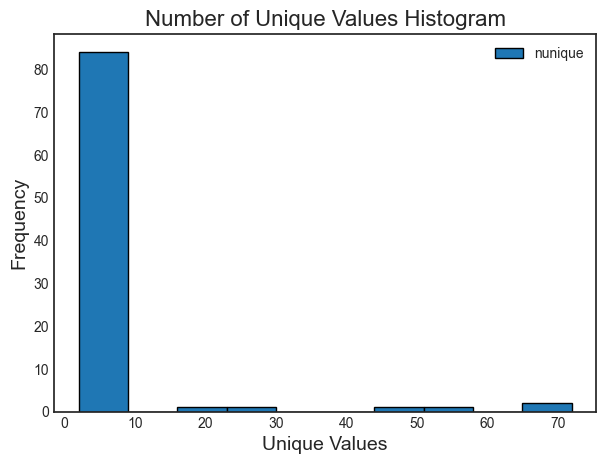

In [53]:
# We can plot a histogram of the number of unique values in each category:
fs.plot_unique()
plt.show()

# Minimum Redundancy Maximum Relevance Feature selection based on mutual information
criteria of max-dependency, max-relevance, and min-redundancy.

In [54]:
pymrmr.mRMR(X_train, 'MIQ', 30)
pymrmr.mRMR(X_train, 'MID', 30)

['subsc_type_Registered',
 'strt_statn_38',
 'strt_statn_114',
 'strt_statn_39',
 'strt_statn_9',
 'subsc_type_Casual',
 'strt_statn_41',
 'strt_statn_10',
 'strt_statn_43',
 'gender_Unknown',
 'strt_statn_5',
 'strt_statn_25',
 'strt_statn_22',
 'strt_statn_33',
 'gender_Female',
 'Day_of_week_cosine',
 'strt_statn_98',
 'Hour_cosine',
 'strt_statn_57',
 'strt_statn_60',
 'strt_statn_48',
 'strt_statn_58',
 'strt_statn_50',
 'gender_Male',
 'strt_statn_81',
 'strt_statn_64',
 'strt_statn_40',
 'strt_statn_47',
 'strt_statn_8',
 'strt_statn_55']

# Regularized linear regressions

Linear Regression with Lasso regularization (L1 penalty)

In [55]:
alphas_lasso = [1e-6, 1e-5, 0.00005, 0.0001, 0.0005, 0.001, 0.01, 0.03, 0.06, 0.09, 0.1, 0.15] 
lassoCV = LassoCV(alphas=alphas_lasso)

Best Lasso alpha: 0.01


Objective did not converge. You might want to increase the number of iterations. Duality gap: 6031804158.742765, tolerance: 2354382.558886901
Objective did not converge. You might want to increase the number of iterations. Duality gap: 4052202078.0712547, tolerance: 1573715.0004743433
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1740720393.5994368, tolerance: 1564818.3338534683
Objective did not converge. You might want to increase the number of iterations. Duality gap: 4192220357.832499, tolerance: 1570201.0844478628


RMSE on Training set : 584.9454955403695


Objective did not converge. You might want to increase the number of iterations. Duality gap: 936725299.8228248, tolerance: 385243.2731140438
Objective did not converge. You might want to increase the number of iterations. Duality gap: 832930310.9268161, tolerance: 412260.1063703313
Objective did not converge. You might want to increase the number of iterations. Duality gap: 977358102.1778201, tolerance: 383341.81962069584


RMSE on Test set : 590.3111103769997
-2.3503261594224263
RMSE: 586.352


Objective did not converge. You might want to increase the number of iterations. Duality gap: 6031804158.774712, tolerance: 2354382.5588869336
Objective did not converge. You might want to increase the number of iterations. Duality gap: 5905095099.215294, tolerance: 2352059.80915904
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3158926320.748785, tolerance: 2351541.0236930526
Objective did not converge. You might want to increase the number of iterations. Duality gap: 5815753790.904579, tolerance: 2365263.5420173495


RMSE: -342270.677 (1454.863)


Objective did not converge. You might want to increase the number of iterations. Duality gap: 6036957796.284697, tolerance: 2356243.010551503


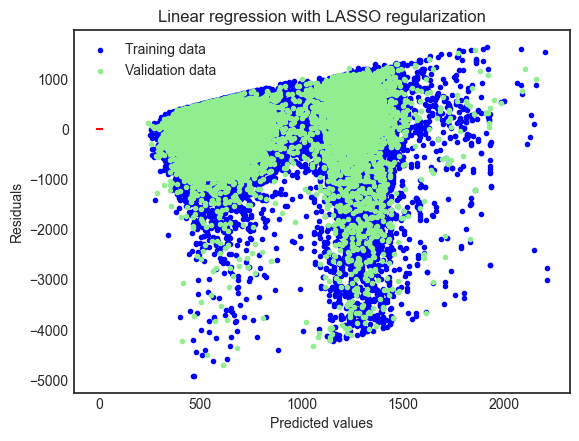

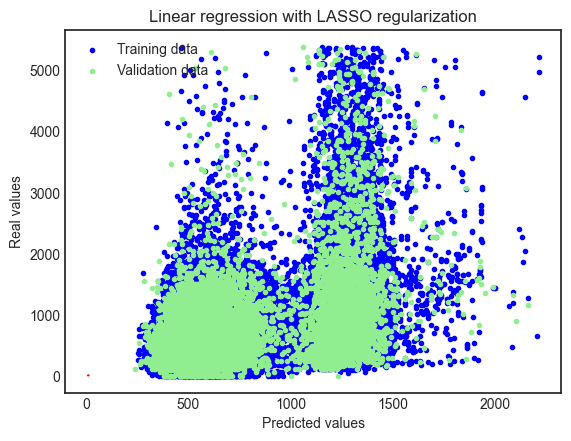

LASSO picked 89 features and eliminated the other 1 features


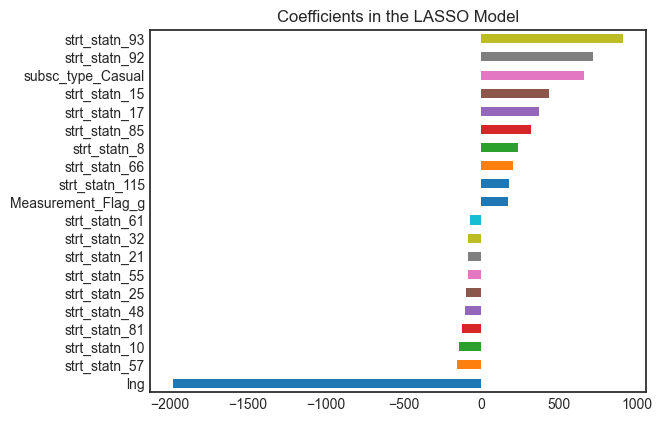

In [56]:
lassoCV.fit(X_train, y_train)
alpha = lassoCV.alpha_
print("Best Lasso alpha:", alpha)
lasso = Lasso(alpha=0.0001)
lasso.fit(X_train, y_train)
print("RMSE on Training set :", rmse_cv(lasso, X_train, y_train).mean())
print("RMSE on Test set :", rmse_cv(lasso, X_test, y_test).mean())
predictions = lasso.predict(X_test)
print(explained_variance_score(predictions, y_test))

# Calculate the Root Mean Squared Error
print("RMSE: %.3f"
      % math.sqrt(np.mean((lasso.predict(X_test) - y_test) ** 2)))

scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
cv_results = cross_val_score(lasso,
                             X, y,
                             cv=kfold,
                             scoring=scoring)

print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

pred_train = lasso.predict(X_train)
pred_test  = lasso.predict(X_test)

# Plot residuals
plt.scatter(pred_train, pred_train - y_train, 
            c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, 
            c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with LASSO regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -15, xmax = 20, color = "red")
plt.show()

# Plot predictions
plt.scatter(pred_train, y_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, y_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with LASSO regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("LASSO picked " + str(sum(coefs != 0)) + \
      " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the LASSO Model")
plt.show()



Linear Regression with Ridge regularization (L2 penalty)

Best alpha : 3.0
RMSE on Training set : 585.0854635695081
RMSE on Test set : 589.4985675669449
-2.4439101466624527
RMSE: 586.239
RMSE: -342378.406 (1690.713)


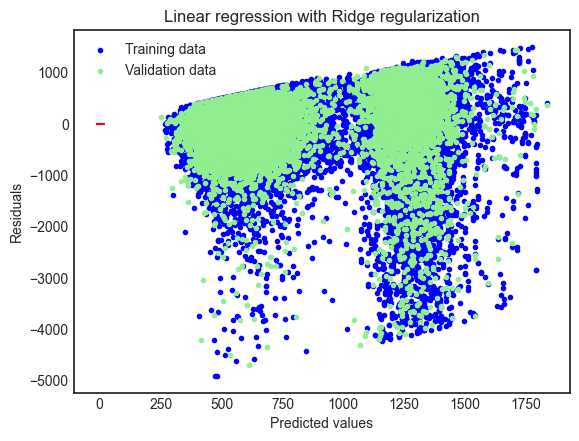

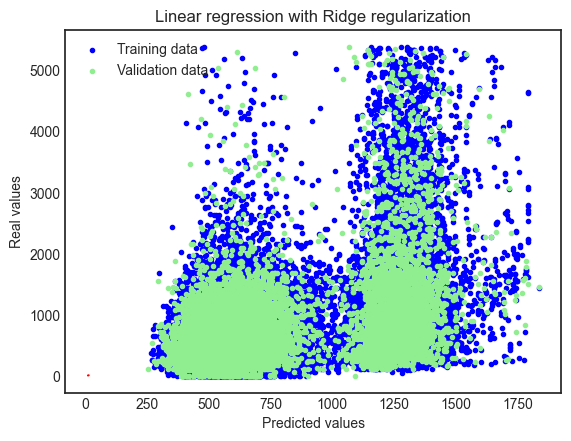

Ridge picked 90 features and eliminated the other 0 features


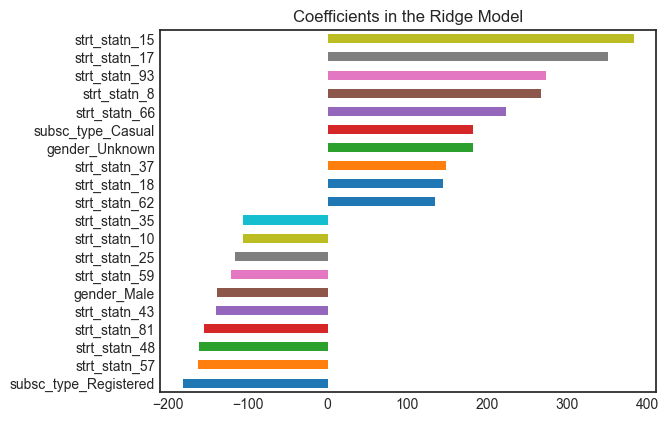

In [57]:
# Linear Regression with Ridge regularization 
ridgeCV = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridgeCV.fit(X_train, y_train)
alpha = ridgeCV.alpha_
print("Best alpha :", alpha)
ridge = Ridge(alpha=60.0)
ridge.fit(X_train, y_train)
print("RMSE on Training set :", rmse_cv(ridge, X_train, y_train).mean())
print("RMSE on Test set :", rmse_cv(ridge, X_test, y_test).mean())

predictions = ridge.predict(X_test)
print(explained_variance_score(predictions, y_test))

# Calculate the Root Mean Squared Error
print("RMSE: %.3f"
      % math.sqrt(np.mean((ridge.predict(X_test) - y_test) ** 2)))

scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
cv_results = cross_val_score(ridge,
                             X, y,
                             cv=kfold,
                             scoring=scoring)

print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

pred_train = ridge.predict(X_train)
pred_test  = ridge.predict(X_test)

# Plot residuals
plt.scatter(pred_train, pred_train - y_train, 
            c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, 
            c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -15, xmax = 20, color = "red")
plt.show()

# Plot predictions
plt.scatter(pred_train, y_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, y_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + \
      " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()



Linear Regression with ElasticNet regularization (L1 and L2 penalty)

Best l1_ratio : 0.5
Best alpha : 0.0003


Objective did not converge. You might want to increase the number of iterations. Duality gap: 8938147692.123306, tolerance: 2354382.558886901
Objective did not converge. You might want to increase the number of iterations. Duality gap: 5991989550.224599, tolerance: 1573715.0004743433
Objective did not converge. You might want to increase the number of iterations. Duality gap: 5916232845.11931, tolerance: 1564818.3338534683
Objective did not converge. You might want to increase the number of iterations. Duality gap: 5952165703.974901, tolerance: 1570201.0844478628


RMSE on Training set : 584.8891429814133


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1442881598.8880858, tolerance: 385243.2731140438
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1545671053.324414, tolerance: 412260.1063703313
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1466729041.801049, tolerance: 383341.81962069584


Test set : 590.081811022107
-2.363051115313278
RMSE: 586.243


Objective did not converge. You might want to increase the number of iterations. Duality gap: 8938147692.123306, tolerance: 2354382.5588869336
Objective did not converge. You might want to increase the number of iterations. Duality gap: 8941870692.614214, tolerance: 2352059.80915904
Objective did not converge. You might want to increase the number of iterations. Duality gap: 8951995570.916456, tolerance: 2351541.0236930526
Objective did not converge. You might want to increase the number of iterations. Duality gap: 8966198022.390537, tolerance: 2365263.5420173495


RMSE: -342228.000 (1484.067)


Objective did not converge. You might want to increase the number of iterations. Duality gap: 8944213532.924646, tolerance: 2356243.010551503


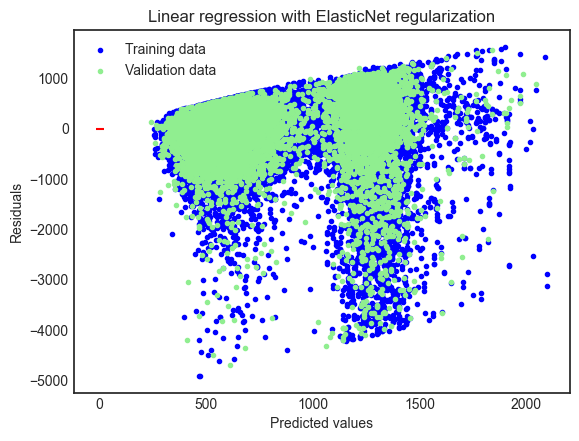

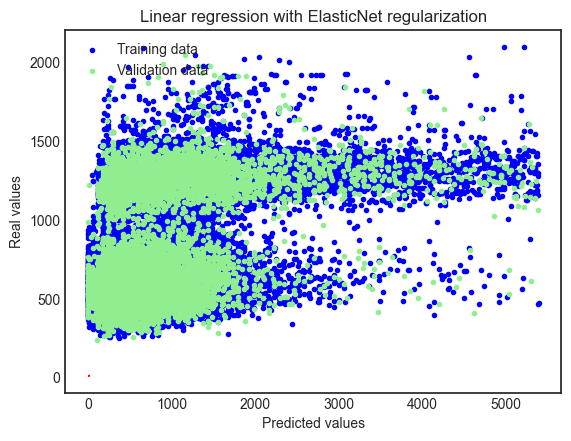

ElasticNet picked 90 features and eliminated the other 0 features


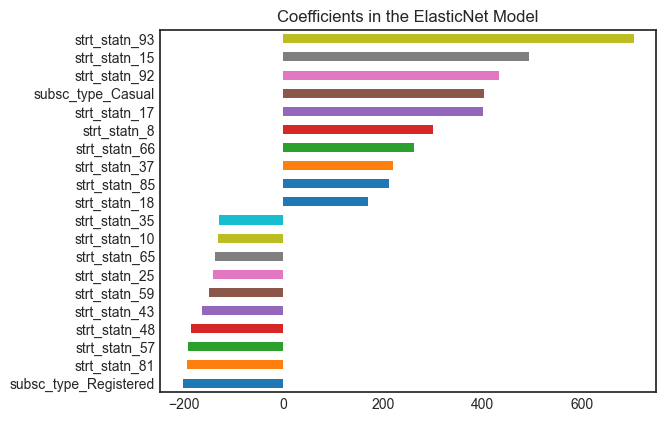

In [58]:
elasticNetCV = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)

elasticNetCV.fit(X_train, y_train)

alpha = elasticNetCV.alpha_
ratio = elasticNetCV.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

elasticNet = ElasticNet(l1_ratio=0.7,alpha=0.0003)

elasticNet.fit(X_train, y_train)

print("RMSE on Training set :", rmse_cv(elasticNet, X_train, y_train).mean())
print("Test set :", rmse_cv(elasticNet, X_test, y_test).mean())

predictions = elasticNet.predict(X_test)
print(explained_variance_score(predictions, y_test))

# Calculate the Root Mean Squared Error
print("RMSE: %.3f"
      % math.sqrt(np.mean((elasticNet.predict(X_test) - y_test) ** 2)))

scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
cv_results = cross_val_score(elasticNet,
                             X, y,
                             cv=kfold,
                             scoring=scoring)

print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

pred_train = elasticNet.predict(X_train)
pred_test  = elasticNet.predict(X_test)

# Plot residuals
plt.scatter(pred_train, pred_train - y_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -15, xmax = 20, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, pred_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(y_test, pred_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                       coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

The optimal L1 ratio used by ElasticNet here is equal to 1, which means it is exactly equal to the Lasso regressor we used earlier (and had it been equal to 0, it would have been exactly equal to our Ridge regressor). The model didn't need any L2 regularization to overcome any potential L1 shortcoming.


# Linear regression with Bayesian Ridge regularization

-2.387603540681912
RMSE: 586.16
-2.387603540681912
RMSE: 586.162
RMSE: -342221.671 (1551.924)


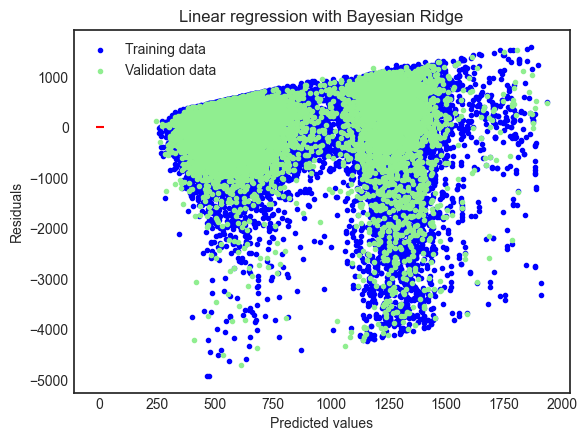

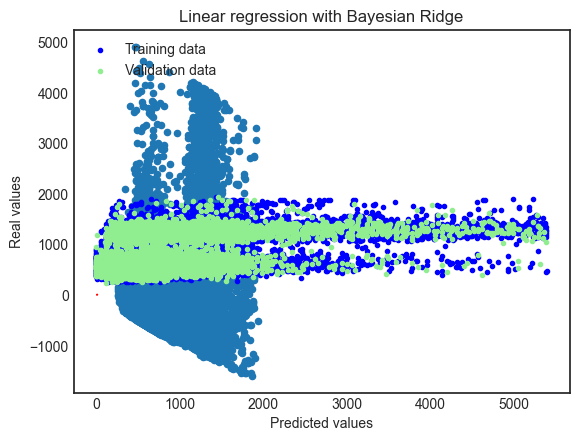

Bayesian picked 90 features and eliminated the other 0 features


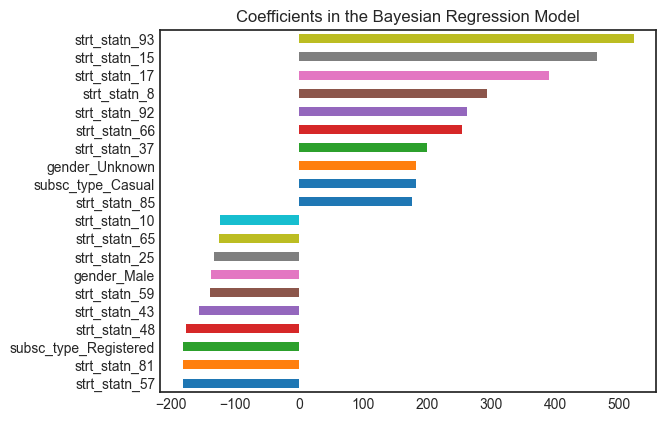

In [59]:
bayes = BayesianRidge()
bayes.fit(X_train, y_train)
predictions = bayes.predict(X_test)
print(explained_variance_score(predictions,y_test))
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((bayes.predict(X_test) - y_test) ** 2)))

predictions = bayes.predict(X_test)
print(explained_variance_score(predictions, y_test))

# Calculate the Root Mean Squared Error
print("RMSE: %.3f"
      % math.sqrt(np.mean((bayes.predict(X_test) - y_test) ** 2)))

scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
cv_results = cross_val_score(bayes,
                             X, y,
                             cv=kfold,
                             scoring=scoring)

print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))

pred_train = bayes.predict(X_train)
pred_test  = bayes.predict(X_test)

# Plot residuals
plt.scatter(pred_train, pred_train - y_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Bayesian Ridge")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -15, xmax = 20, color = "red")
plt.show()


import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":bayes.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Bayesian Regression")

# Plot predictions
plt.scatter(y_train, pred_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(y_test, pred_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Bayesian Ridge")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(bayes.coef_, index = X_train.columns)
print("Bayesian picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                       coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Bayesian Regression Model")
plt.show()

col={'Train Error':pred_train,'Test Error':pred_train}
models=['Ridge Regression',#'Linear Regression','Elastic Net regression',
        #'Bayesian Regression',
        #'Random Forest','Gradient Boosting', 
       ]

Least Angle regression (LARs)

Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=4.658e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.719e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.226e-01, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=8.848e-02, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Droppin

RMSE on Training set : 586.1363170504634
Test set : 589.6355569788624
-2.7146920264005976
RMSE: 587.020


Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=3.577e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.036e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.320e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=9.274e-02, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping 

RMSE: -343775.908 (1541.046)


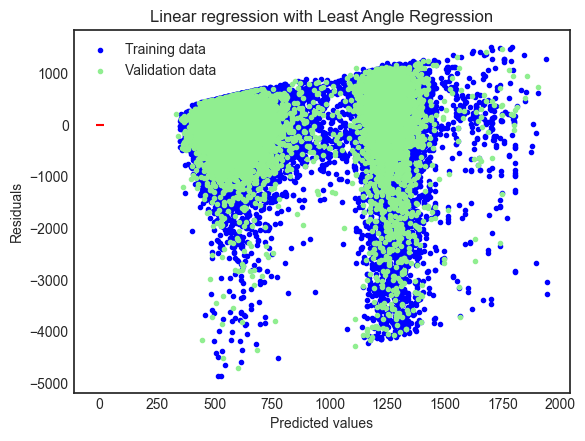

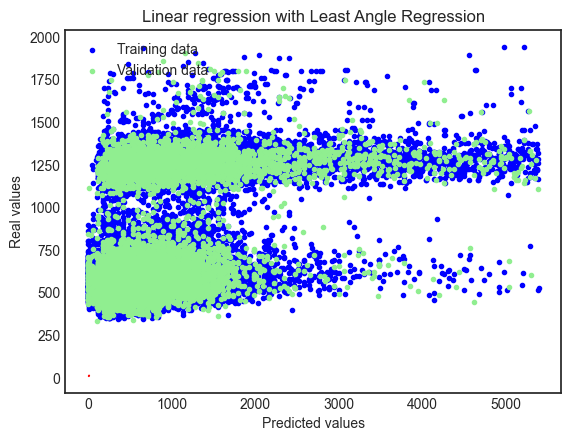

LARS picked 50 features and eliminated the other 40 features


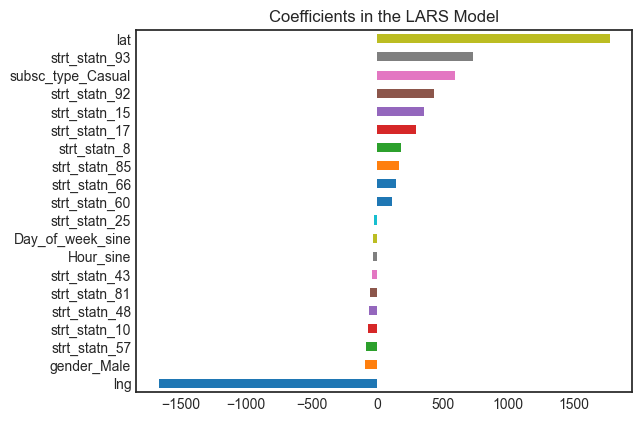

In [60]:
lars = Lars(n_nonzero_coefs=50)
lars.fit(X_train, y_train)
print("RMSE on Training set :", rmse_cv(lars, X_train, y_train).mean())
print("Test set :", rmse_cv(lars, X_test, y_test).mean())
predictions = lars.predict(X_test)
print(explained_variance_score(predictions, y_test))

# Calculate the Root Mean Squared Error
print("RMSE: %.3f"
      % math.sqrt(np.mean((lars.predict(X_test) - y_test) ** 2)))
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
cv_results = cross_val_score(lars,
                             X, y,
                             cv=kfold,
                             scoring=scoring)
print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))
pred_train = lars.predict(X_train)
pred_test  = lars.predict(X_test)
# Plot residuals
plt.scatter(pred_train, pred_train - y_train, 
            c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, 
            c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Least Angle Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -15, xmax = 20, color = "red")
plt.show()
# Plot predictions
plt.scatter(y_train, pred_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(y_test, pred_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Least Angle Regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()
# Plot important coefficients
coefs = pd.Series(lars.coef_, index = X_train.columns)
print("LARS picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the LARS Model")
plt.show()

# Tree-based regression

Random Forest Regressor

-0.25449444988966174
RMSE: 542.12
RMSE: -294934.631 (3763.653)


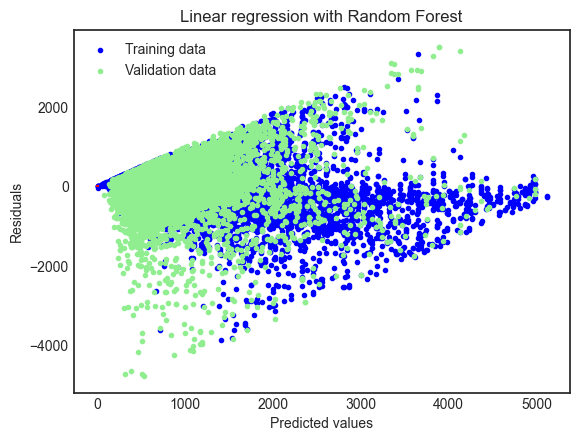

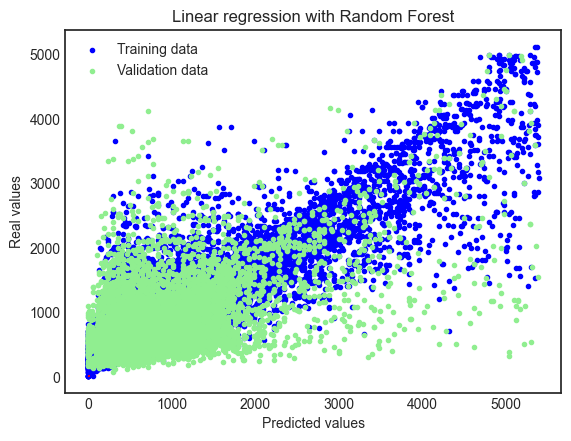

RandomForest picked 90 features and eliminated the other 0 features


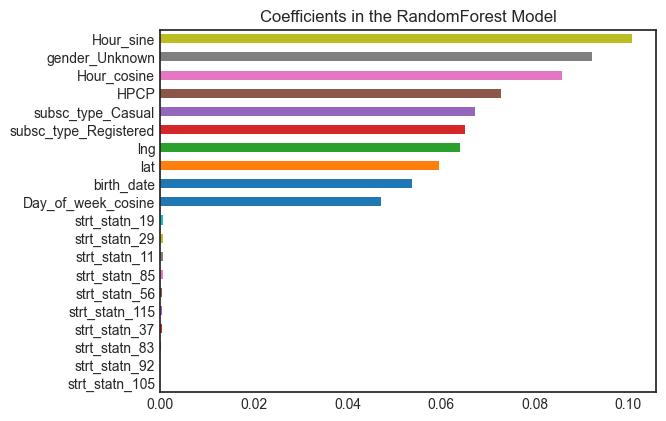

In [61]:
rfr = RandomForestRegressor(n_jobs=1, criterion='mse', random_state=42)
rfr.fit(X_train, y_train)
predictions = rfr.predict(X_test)
print(explained_variance_score(predictions,y_test))
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((rfr.predict(X_test) - y_test) ** 2)))
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
cv_results = cross_val_score(rfr,
                             X, y,
                             cv=kfold,
                             scoring=scoring)
print('RMSE: %.3f (%.3f)' % (cv_results.mean(), cv_results.std()))
pred_train = rfr.predict(X_train)
pred_test  = rfr.predict(X_test)
# Plot residuals
plt.scatter(pred_train, pred_train - y_train, 
            c = "blue", marker = ".", label = "Training data")
plt.scatter(pred_test, pred_test - y_test, 
            c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Random Forest")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -15, xmax = 20, color = "red")
plt.show()
# Plot predictions
plt.scatter(y_train, pred_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(y_test, pred_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear regression with Random Forest")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()
# Plot important coefficients
coefs = pd.Series(rfr.feature_importances_, index = X_train.columns)
print("RandomForest picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                       coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the RandomForest Model")
plt.show()


# Regression model comparison

By comapring several different regressoin alorithm we can establish the baseline model for further study and improvement, e.g. model interpretation and optimization.

In [62]:
# Prepare models
models = []
models.append(('linear', LinearRegression()))
models.append(('lasso', Lasso()))
models.append(('ridge', Ridge()))
models.append(('elasticnet', ElasticNet()))
models.append(('bayesridge', BayesianRidge()))
models.append(('lars', Lars(n_nonzero_coefs=50)))
models.append(('lassolarsic', LassoLarsIC()))
models.append(('randomforest', RandomForestRegressor()))
models.append(('gradientboost', GradientBoostingRegressor()))
models.append(('xgboost', XGBRegressor()))

# Evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_squared_error'

for name, model in models:

    kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
    
    cv_results = cross_val_score(model,
                                 X, y,
                                 cv=kfold,
                                 scoring=scoring)
    results.append((-1)*cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, (-1)*cv_results.mean(), cv_results.std())
    print(msg)

linear: 342304.609824 (1485.289497)
lasso: 345471.710842 (1950.525249)
ridge: 342258.257779 (1460.348687)
elasticnet: 366060.437379 (2980.613905)
bayesridge: 342221.671369 (1551.924106)


Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=3.577e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.036e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.320e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=9.274e-02, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping 

lars: 343775.907720 (1541.046262)


Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=3.577e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.036e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.320e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=9.274e-02, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping 

lassolarsic: 342427.552160 (1201.066504)
randomforest: 295030.359305 (3792.144850)
gradientboost: 334408.393133 (1038.551769)
xgboost: 311887.565403 (1697.404643)


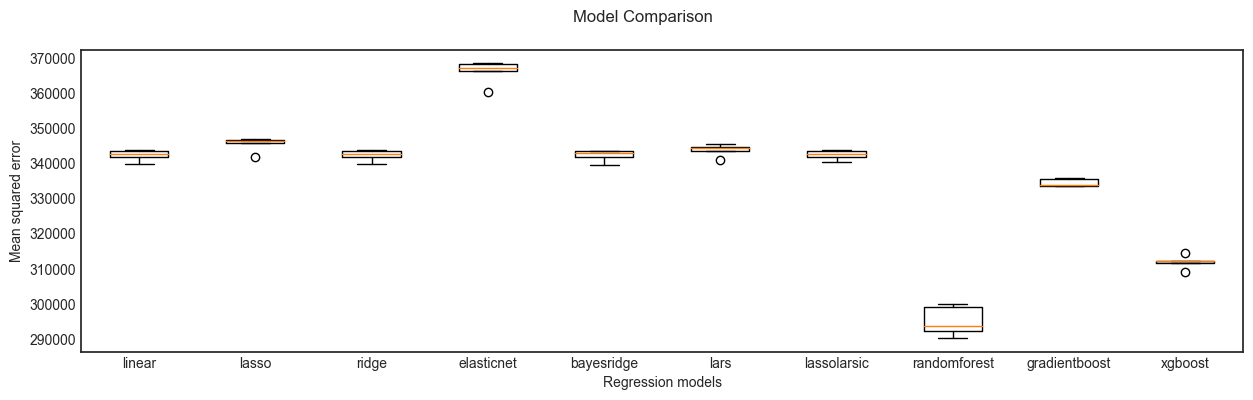

In [63]:
# Boxplot algorithm comparison
fig = plt.figure(figsize=(15,4))
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names) 
ax.set_ylabel('Mean squared error')
ax.set_xlabel('Regression models')
plt.show()

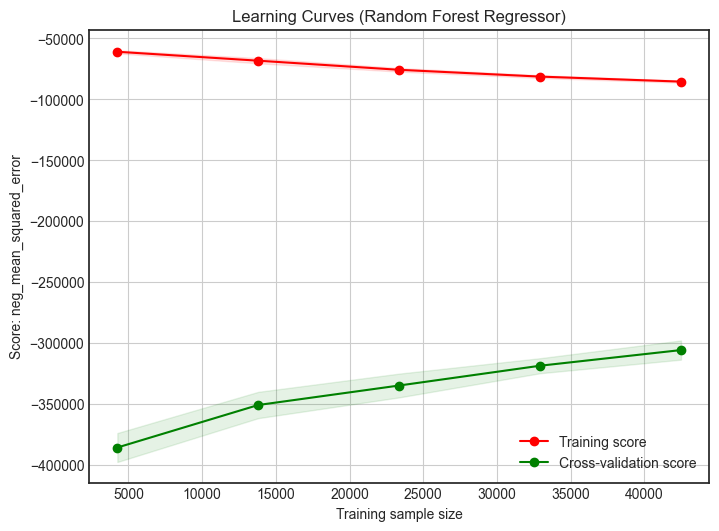

None

In [64]:
# Check if the model would benefit from data
pipe = make_pipeline(rfr)

title = "Learning Curves (Random Forest Regressor)"

plot_learning_curve(pipe, title, X_train, y_train, 
                    cv=None, 
                    scoring='neg_mean_squared_error', 
                    n_jobs=1,
                    train_sizes=np.linspace(.1, 1.0, 5))

In [65]:
#from sklearn.model_selection import validation_curve
from sklearn import model_selection
## Define validation plots
def validation_curve(estimators, X_train, y_train, param_name,
                        params, param_range, cv=3,
                        scoring="neg_mean_squared_error", logx=False,
                        n_jobs=1):
    """
    Draw histogram of the DataFrame's series comparing the distribution
    in `signal` to `background`.
    Parameters
    ----------
    models : dictionary, shape = [n_models]
    X : DataFrame, shape = [n_samples, n_classes]
    y : DataFrame, shape = [n_classes]
    param_range :
    param_name :
    cv :
    scoring :
    n_jobs :
    Returns
    -------
    plot : matplotlib plot
    """

    """
    Describe possible kwargs values
    Keys
    ----------
    """

    # deep compy of model(s)
    models = estimators

    # line width
    lw = 2

    # check to see if models is a list
    if not isinstance(models, list):
        models = [models]
    # check to see if model is a pipeline object or not
    if isinstance(models[0], sklearn.pipeline.Pipeline):
        data_type = type(models[0]._final_estimator)
    else:
        data_type = type(models[0])

    # plot title
    name = filter(str.isalnum, str(data_type).split(".")[-1])
    title = "Validation Curves (%s)" % name

    # create blank canvas
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    #ax.set_facecolor('white')
    
    for n, model in enumerate(models):
        print('start validation scores ...')
        #print(model.get_params().keys())
        # validation scores
        print('param_name:', param_name)
        print('param_range:', param_range)
        train_scores, test_scores = model_selection.validation_curve(
            model, X_train, y_train,
            param_name=param_name,
            param_range=param_range, cv=cv,
            scoring=scoring, n_jobs=n_jobs)
        print('end validation scores ...')
        # mean train scores
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std  = np.std(train_scores, axis=1)

        # mean test scores
        test_scores_mean  = np.mean(test_scores, axis=1)
        test_scores_std   = np.std(test_scores, axis=1)

        # extract information for legend
        label = 'placeholder'

        # plot validation curve
        if logx is True:
            plt.semilogx(param_range, train_scores_mean, '--',
                            label=label.replace('placeholder','Training'),
                            color="darkorange", lw=lw)

            plt.semilogx(param_range, test_scores_mean,
                            label=label.replace('placeholder','Test'),
                            color="navy", lw=lw)
        else:
            plt.plot(param_range, train_scores_mean, '--',
                        label=label.replace('placeholder','Training'),
                        color="darkorange", lw=lw)

            plt.plot(param_range, test_scores_mean,
                        label=label.replace('placeholder','Test'),
                        color="navy", lw=lw)

        plt.fill_between(param_range, train_scores_mean - train_scores_std,
                            train_scores_mean + train_scores_std, alpha=0.2,
                            color="darkorange", lw=lw)

        plt.fill_between(param_range, test_scores_mean - test_scores_std,
                            test_scores_mean + test_scores_std, alpha=0.2,
                            color="navy", lw=lw)

        #colour = test_line[-1].get_color()
        #plt.axvline(x=best_iter, color=colour)

    # plot title
    plt.title(title, fontsize=14)

    name_list = list(name)
    name_str = ' '.join(map(str, name_list))
    plt.xlabel(str(param_name).replace(name_str+'__',''))
    plt.ylabel(scoring)

    # x-axis range
    plt.xlim([min(param_range), max(param_range)])

    plt.legend(loc='best', frameon=False, fancybox=True, fontsize=12)

    return plt.show()

In [66]:
estimator = RandomForestRegressor(n_jobs=1, criterion='mse', 
                                  min_samples_leaf=10, random_state=seed)
# n_estimators=10,  max_depth=None, criterion=’mse’, min_samples_leaf=1,

start validation scores ...
param_name: n_estimators
param_range: [ 2 10 18 26]
end validation scores ...


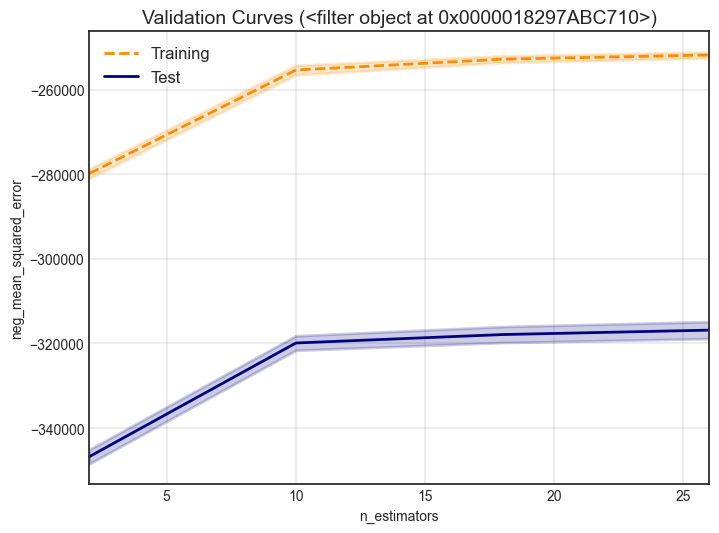

In [67]:
# Hyper-parameter validation curves
param_name = 'n_estimators'
param_range = np.linspace(2, 26, num=4, dtype=int)
params = {'n_estimators': 1}

validation_curve(estimator,
                 X_train, y_train,
                 param_name,
                 params,
                 param_range,
                 scoring="neg_mean_squared_error",
                 cv=3
                )

start validation scores ...
param_name: max_depth
param_range: [4, 5, 6, 7, 8, 9, 10, 15, 25]
end validation scores ...


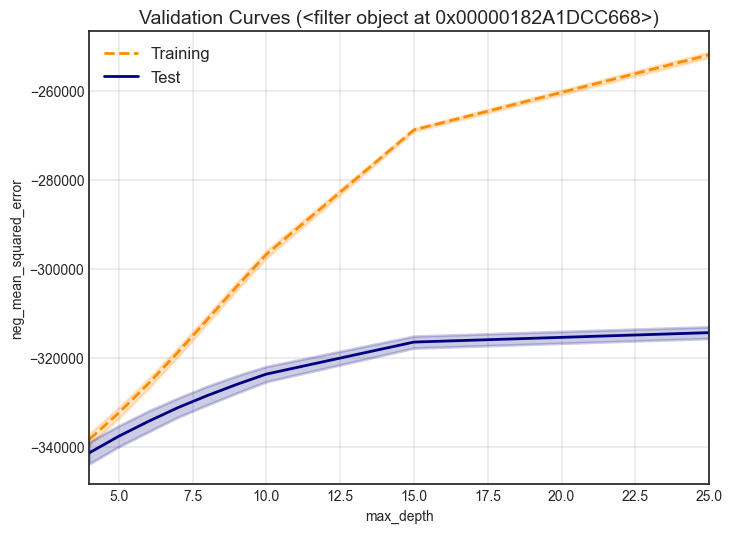

In [68]:
param_name = 'max_depth'
param_range = [4, 5, 6, 7, 8, 9, 10, 15, 25]
params = {'max_depth': param_range}

validation_curve(estimators=estimator,
                 X_train=X_train, 
                 y_train=y_train,
                 param_name=param_name,
                 params=params,
                 param_range=param_range,
                 scoring="neg_mean_squared_error",
                 cv=3
                )

start validation scores ...
param_name: min_samples_leaf
param_range: [1, 5, 10, 15]
end validation scores ...


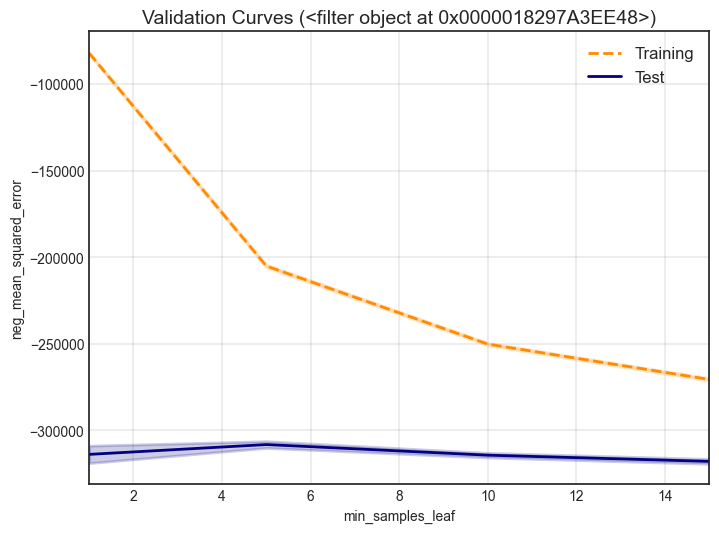

In [69]:
name = 'estimator'
param_name = 'min_samples_leaf'
param_range = [1, 5, 10, 15]
params = {name+'min_samples_leaf': 1}

validation_curve(estimator,
                 X_train, y_train,
                 param_name,
                 params,
                 param_range,
                 scoring="neg_mean_squared_error",
                 cv=3
                )

Model tuning with Bayesian Optimization

In [70]:
from sklearn.model_selection import StratifiedKFold
    
# Number of iterations
n_calls = 11

# K-fold stratified cross-validaiton
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

import skopt
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer

# Configuration space
space  = [
    Integer(15, 35,                       name='n_estimators'),
    Integer(10, 30,                       name='max_depth'),
    Integer(5,  10,                       name='min_samples_leaf'),
    #Real(10**-3, 9.*10**-1, "log-uniform", name='amma'),
    #Real(10**-3, 9.*10**-1, "log-uniform", name='learning_rate'),   
]

# this decorator allows your objective function to receive the parameters as keyword arguments. 
# This is particularly convenient when you want to set scikit-learn
# estimator parameters

# Objective function
@use_named_args(space)
def objective(**params):

    estimator.set_params(**params)
    
    score = -np.mean(cross_val_score(estimator, 
                                     X, y, #X_train, y_train
                                     cv=3, 
                                     #n_jobs=-1,
                                     scoring="neg_mean_absolute_error"))

    return score

print('Processing Bayesian optimization...')

# Bayesian optimization based on Gaussian process regression search (controlling the exploration-exploitation trade-off)
estimator_gp_ei = gp_minimize(func=objective,           # the function to minimize
                              dimensions=space,         # the bounds on each dimension of the optimization space
                              acq_func="EI",            # the acquisition function ("EI", "LCB", "PI")
                              n_calls=n_calls,          # the number of evaluations of the objective function (Number of calls to func)
                              random_state=seed,        # the random seed  
                              #x0=default_parameters,    # help the optimizer locate better hyper-parameters faster with default values
                              n_jobs=1)                 # the number of threads to use

Processing Bayesian optimization...


In [71]:
print("Best score=%.4f (EI)" % estimator_gp_ei.fun)
print("""Expected Improvement (EI) best parameters:
- n_estimators= %s  
- max_depth= %s
- min_samples_leaf= %s """ % (str(estimator_gp_ei.x[0]), str(estimator_gp_ei.x[1]),
                              str(estimator_gp_ei.x[2])))

Best score=375.8168 (EI)
Expected Improvement (EI) best parameters:
- n_estimators= 35  
- max_depth= 10
- min_samples_leaf= 7 


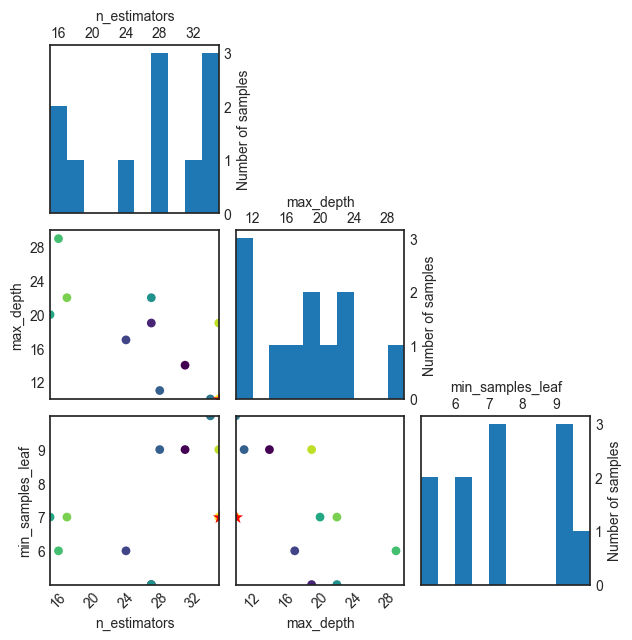

In [72]:
from skopt.plots import plot_evaluations

# Evalution
plot_evaluations(estimator_gp_ei, bins=10, 
                 dimensions=['n_estimators', 'max_depth', 'min_samples_leaf'])
plt.show()

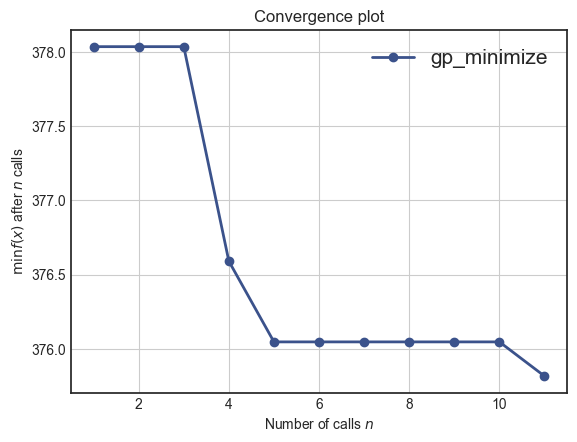

In [73]:
from skopt.plots import plot_convergence

# Convergence (previously looked better enquire what is going on)
plot_convergence(("gp_minimize", estimator_gp_ei))
plt.legend(loc="best", prop={'size': 15}, numpoints=1)
plt.show()

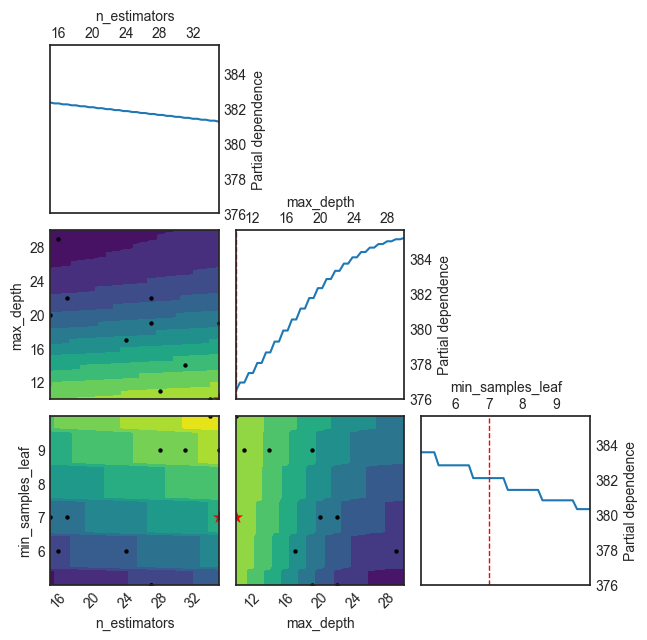

In [74]:
from skopt.plots import plot_objective

plot_objective(estimator_gp_ei)
plt.show()

In [75]:
classifier = RandomForestRegressor(n_estimators= 35, 
                                   max_depth= 19,
                                   min_samples_leaf= 9,
                                   criterion='mse', 
                                   random_state=seed)
classifier.fit(X, y)

RandomForestRegressor(max_depth=19, min_samples_leaf=9, n_estimators=35,
                      random_state=42)

In [76]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((classifier.predict(X_test) - y_test) ** 2)))

RMSE: 500.28


# Model interpretability
Model interpretability with SHapley Additive exPlanations a Coalition Game Theory approach.

In [77]:
# load JS in order to use some of the plotting functions from the shap
# package in the notebook
shap.initjs()

estimator = rfr #RandomForestRegressor(n_jobs=1, criterion='mse', random_state=42)
#estimator.fit(X_train, y_train)

# create our SHAP explainer
shap_explainer = shap.TreeExplainer(estimator)
#shap_explainer = shap.KernelExplainer(estimator.predict, X_test)

# calculate the shapley values for our test set
test_shap_vals = shap_explainer.shap_values(X_test[0:100])
# plot the explanation for a single prediction
shap.force_plot(shap_explainer.expected_value, test_shap_vals[90, :], X_test.iloc[90, :])

auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


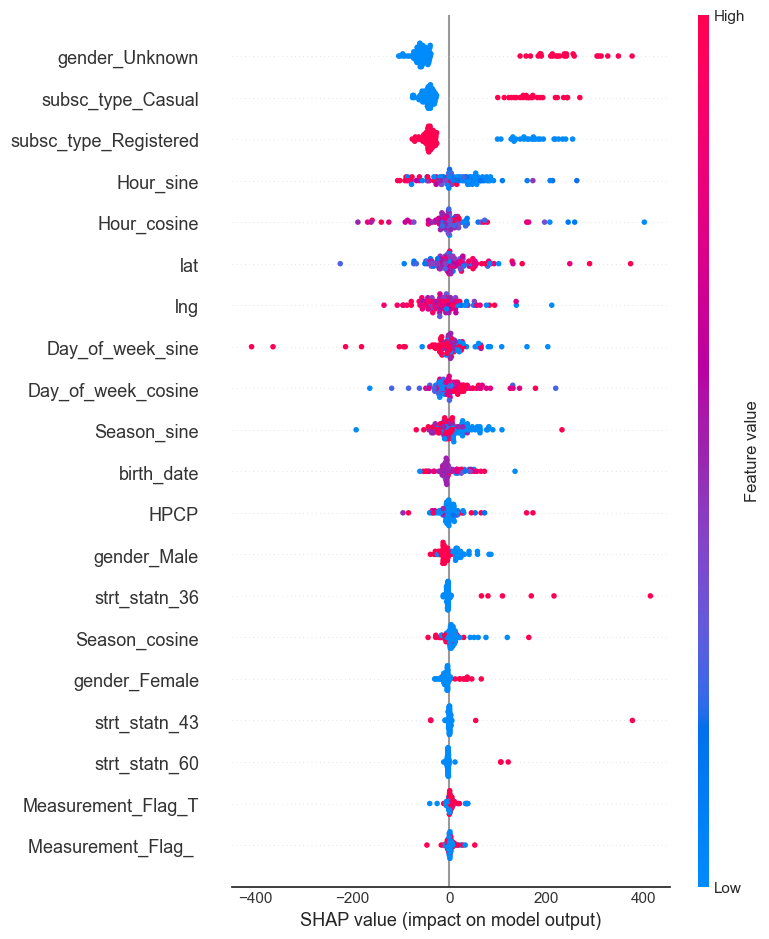

In [78]:
# Plot the distribution of each feature's SHAP 
shap.summary_plot(test_shap_vals, X_test[0:100], auto_size_plot=False)

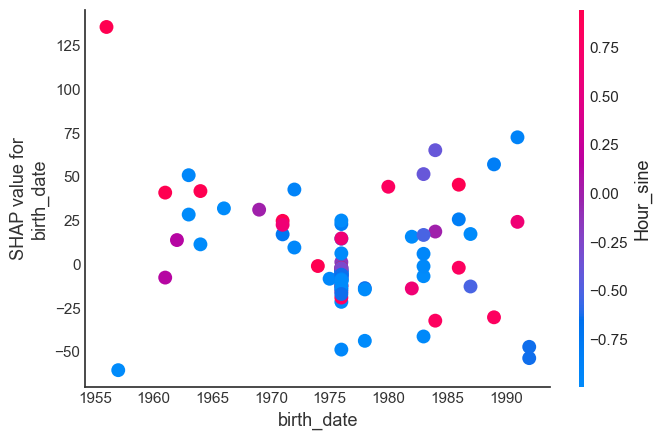

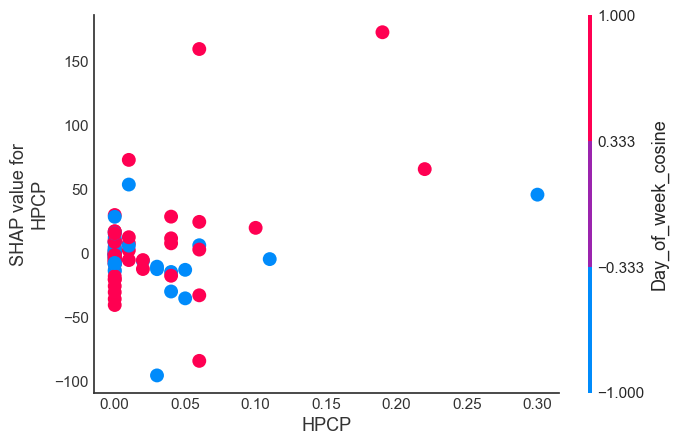

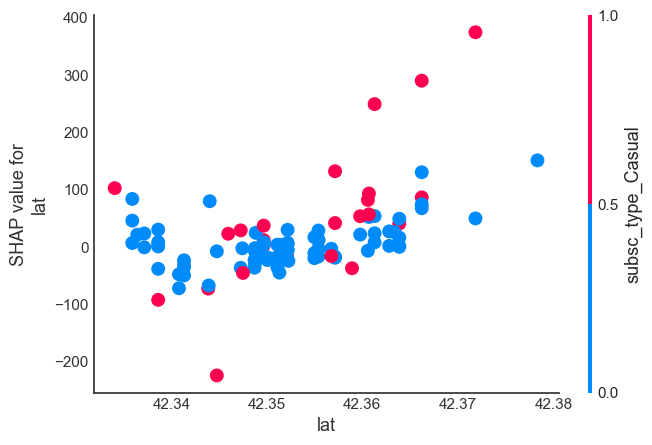

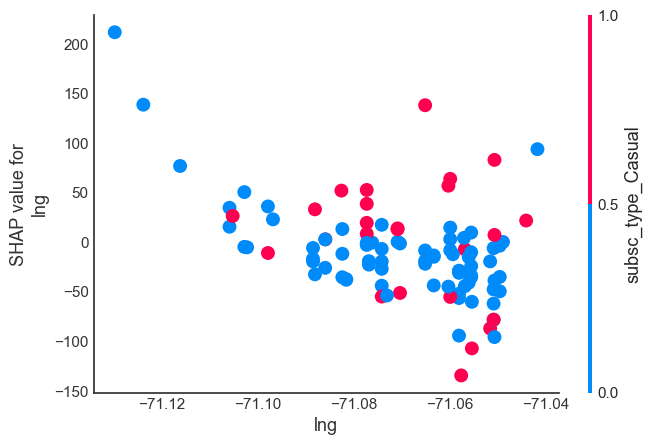

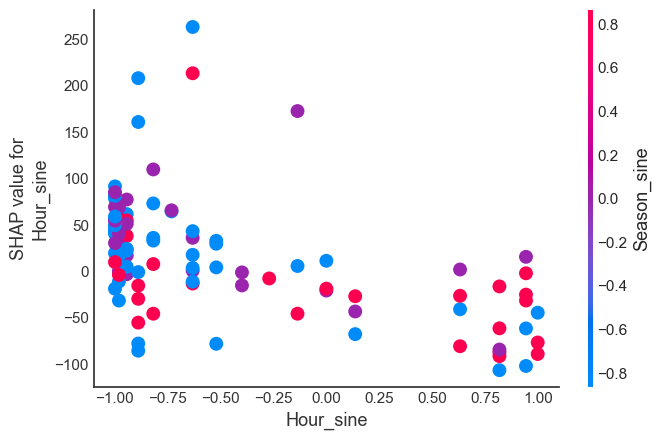

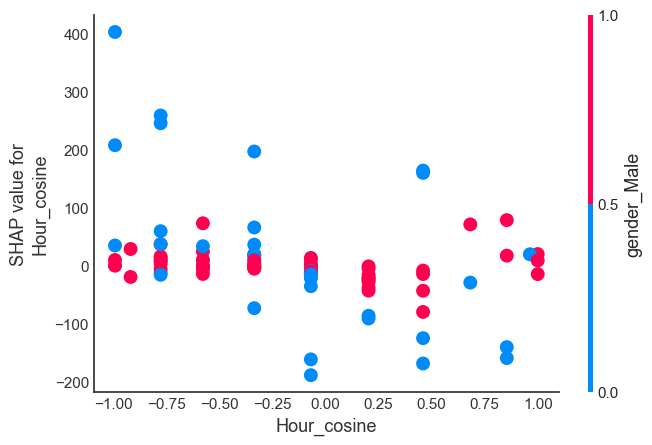

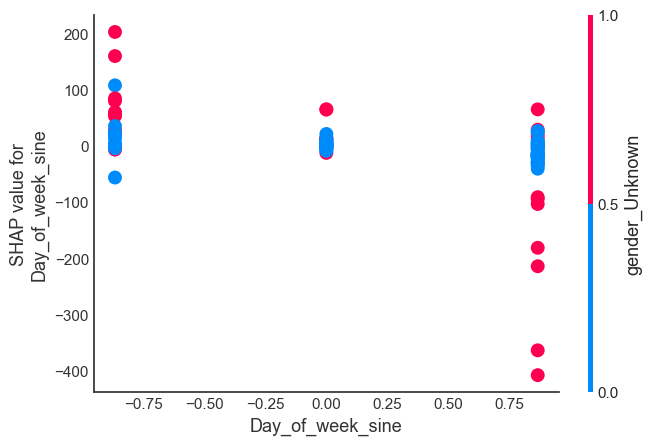

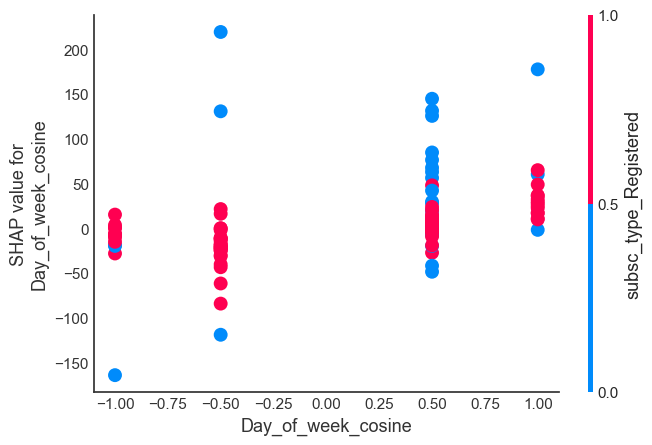

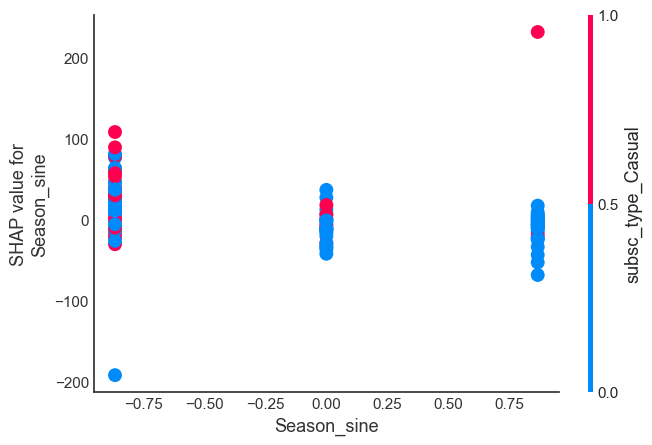

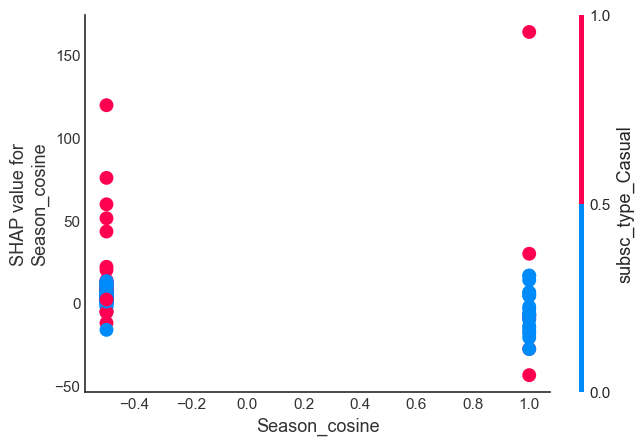

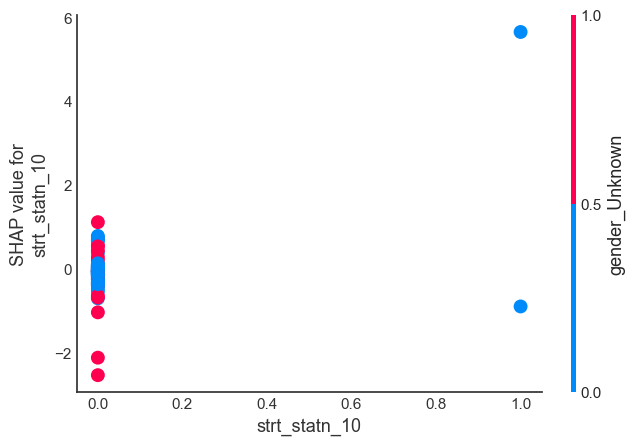

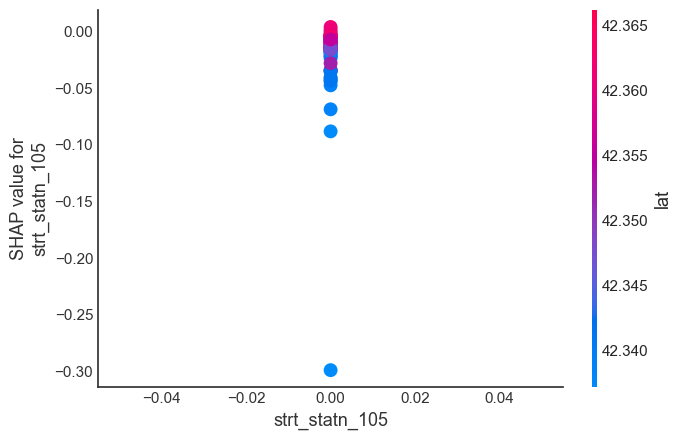

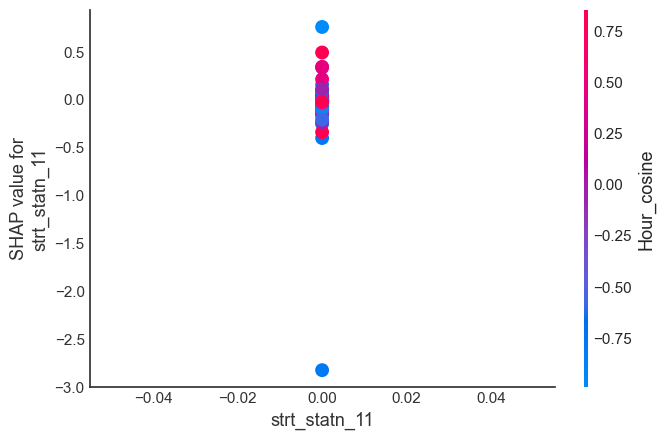

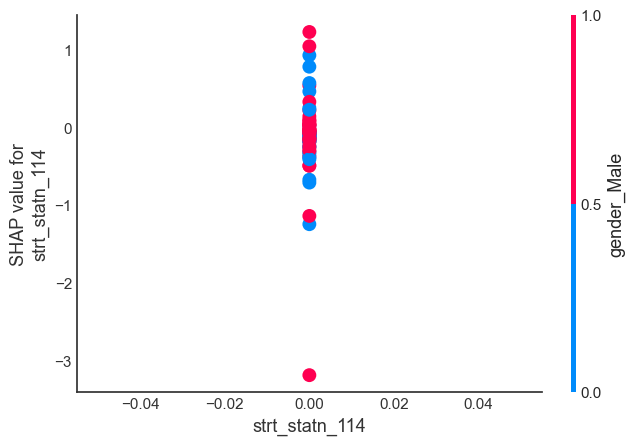

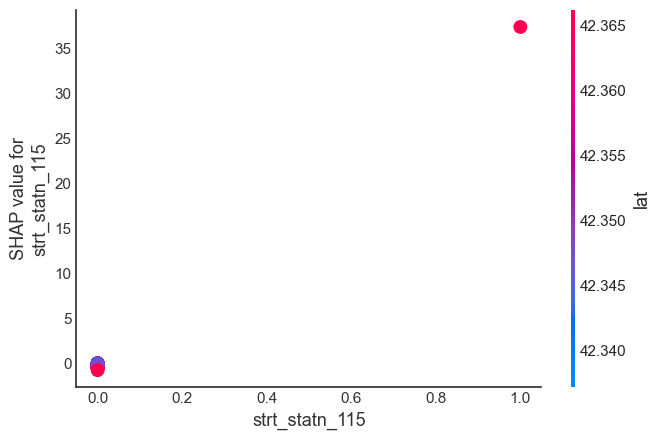

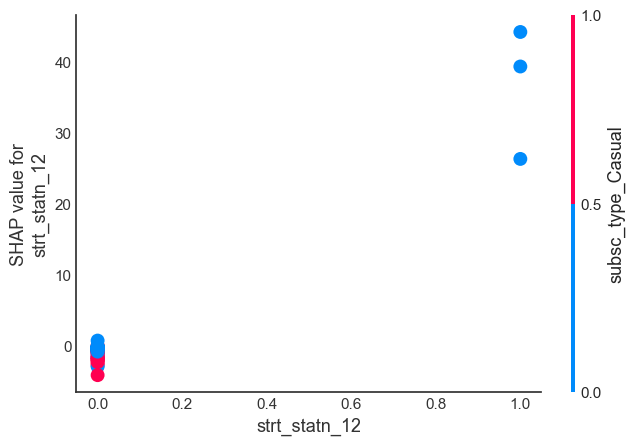

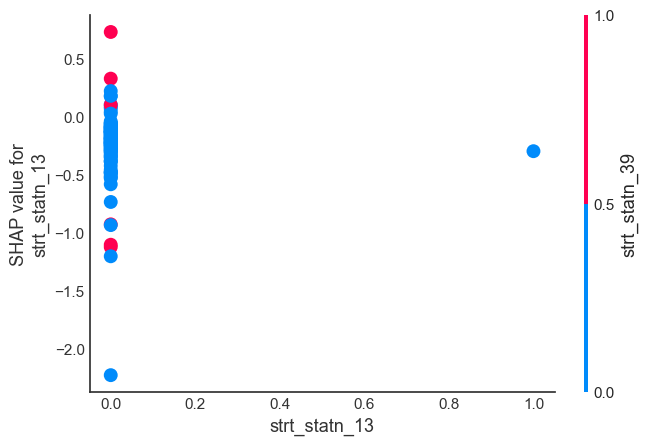

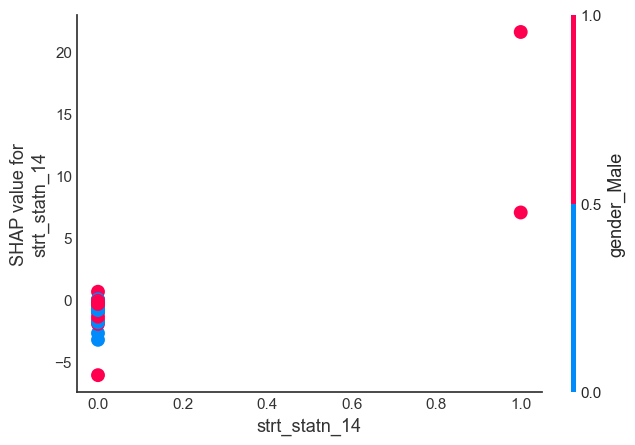

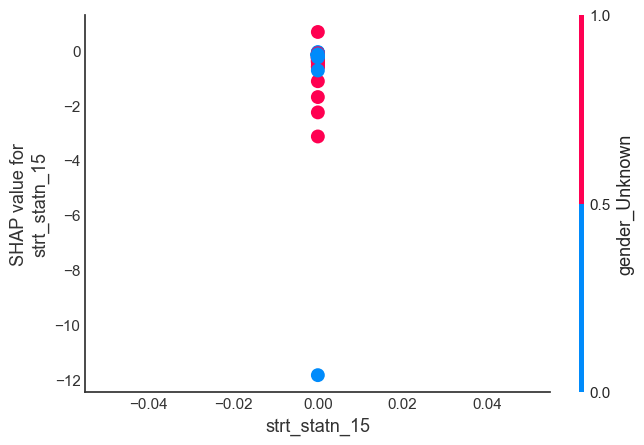

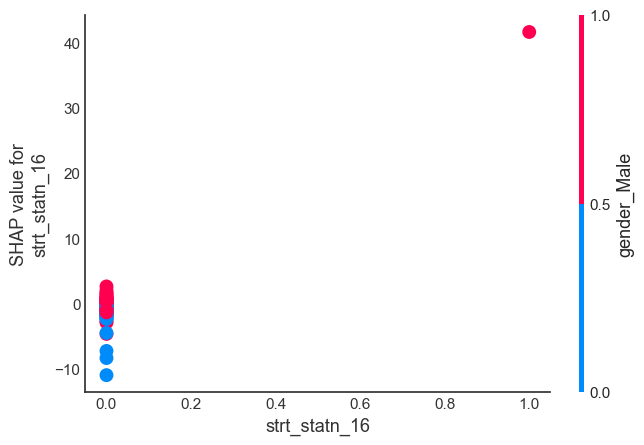

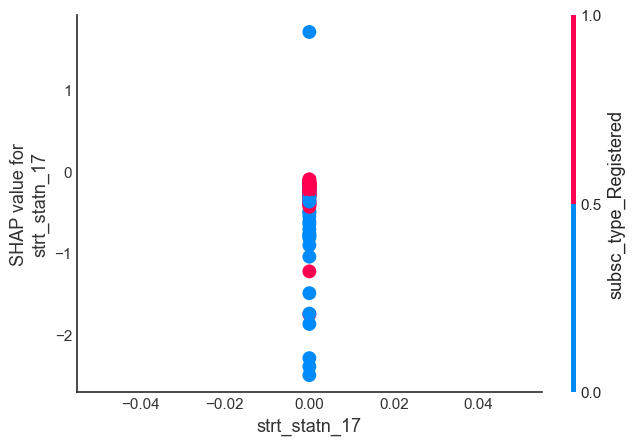

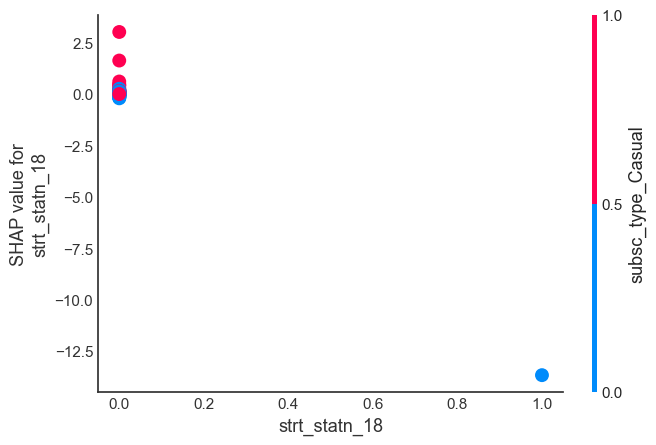

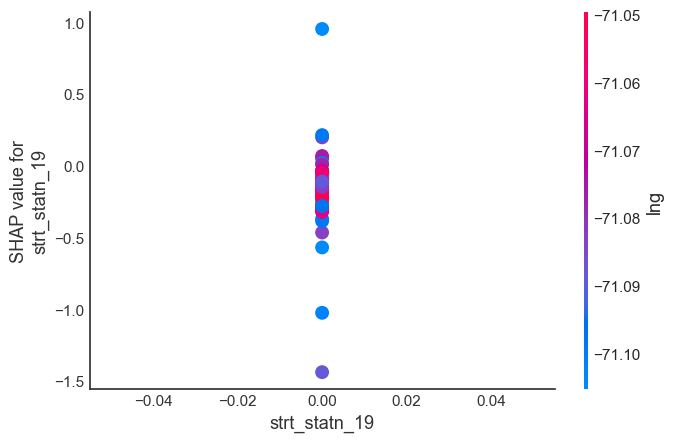

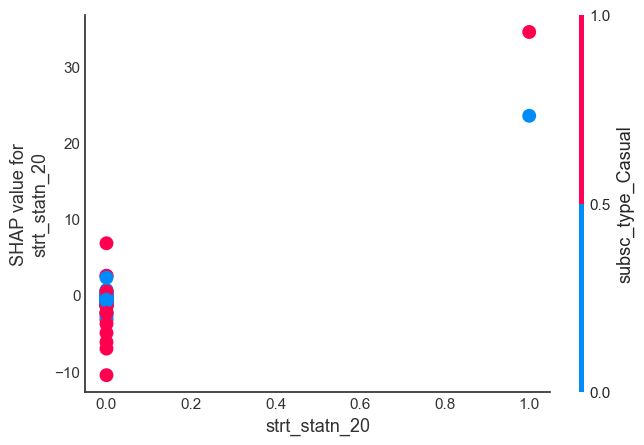

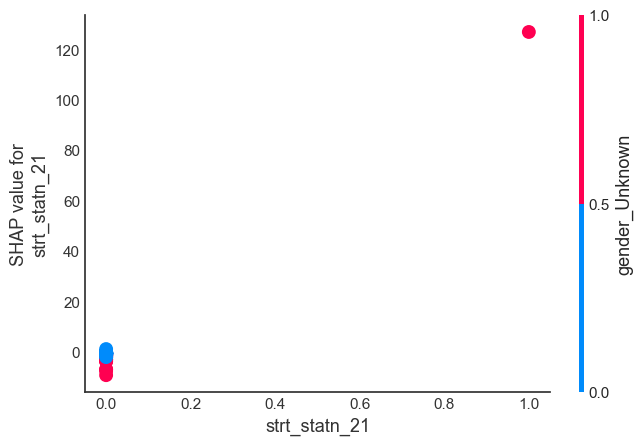

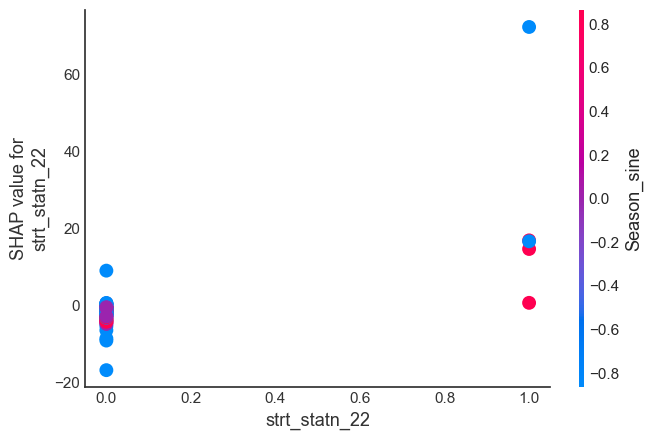

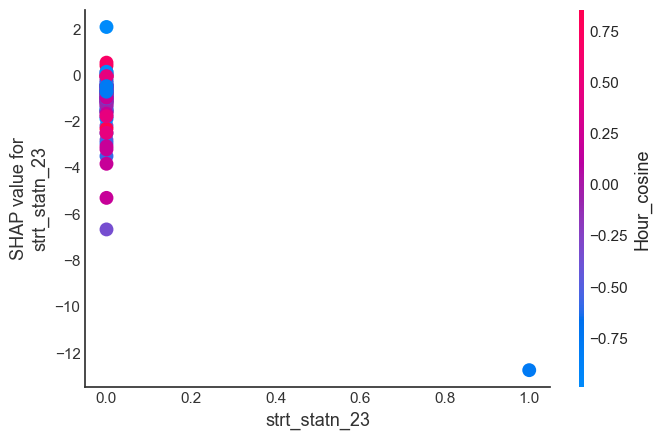

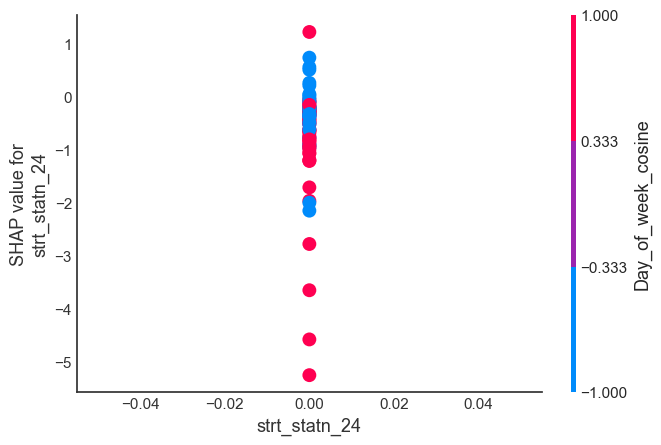

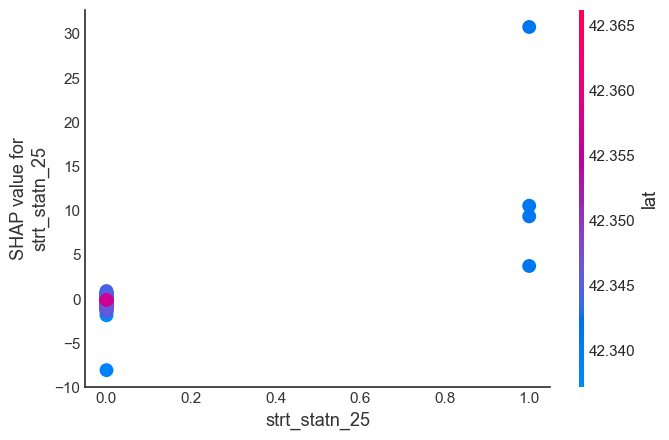

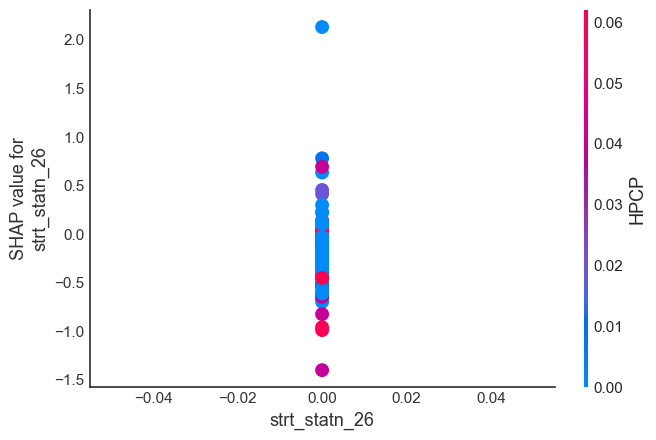

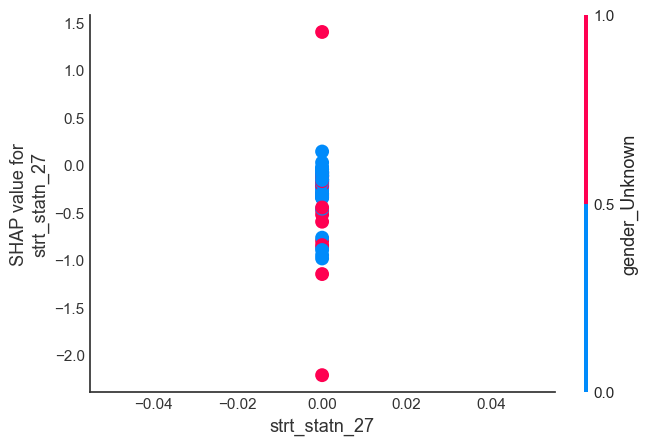

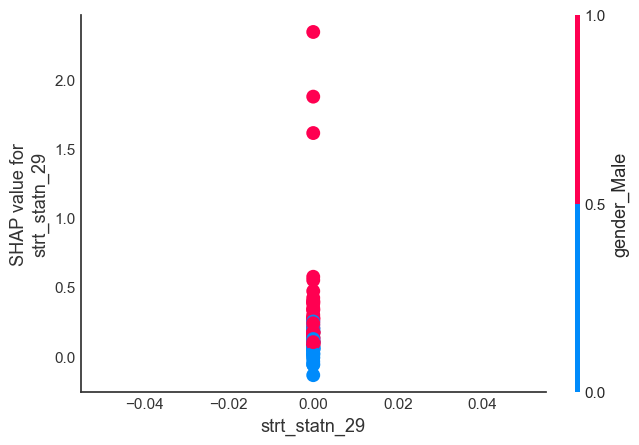

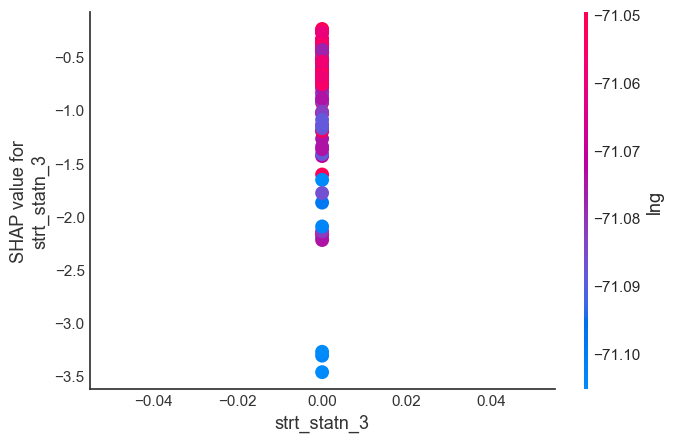

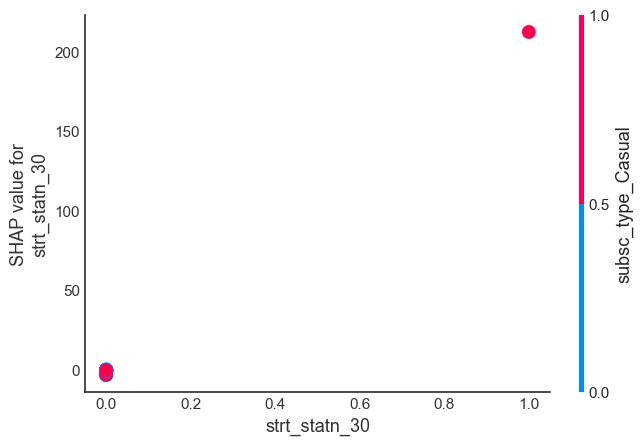

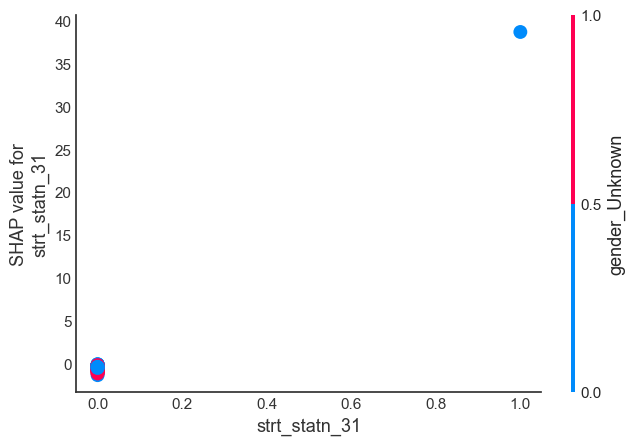

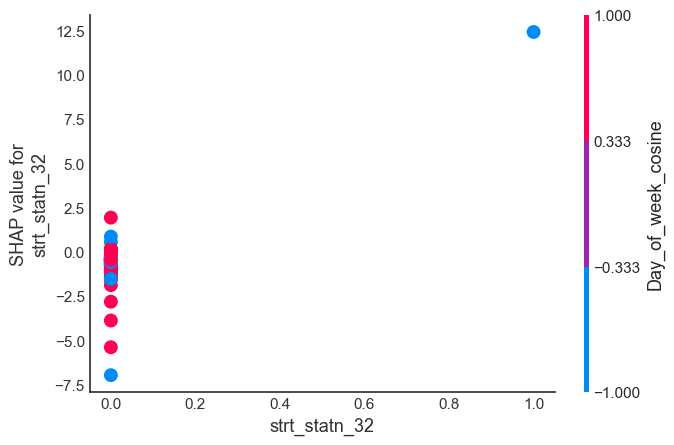

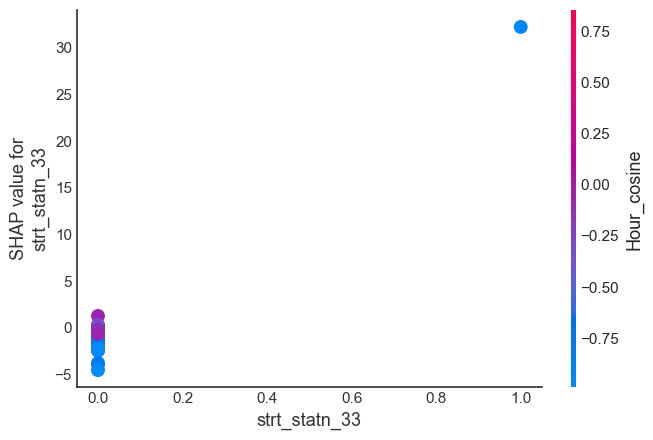

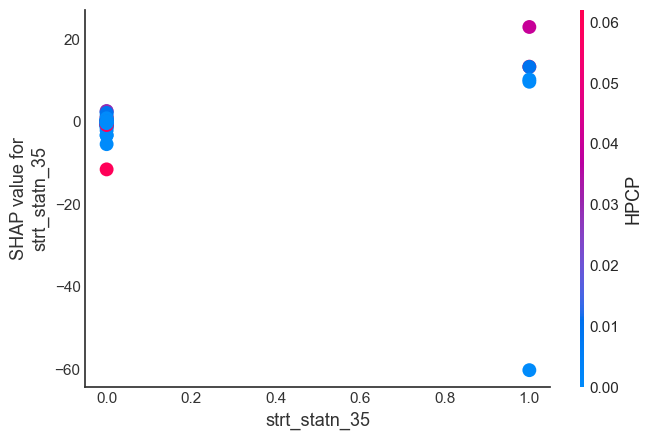

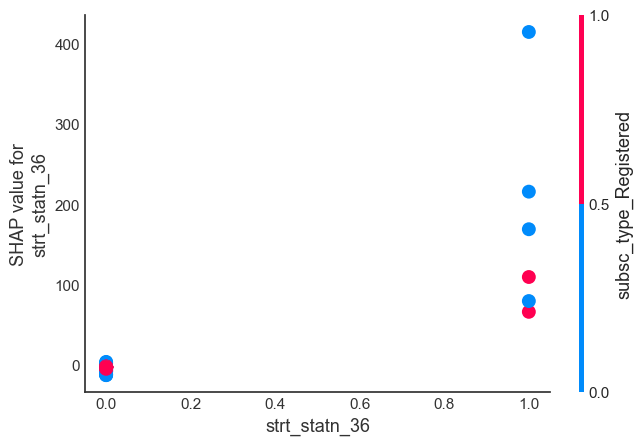

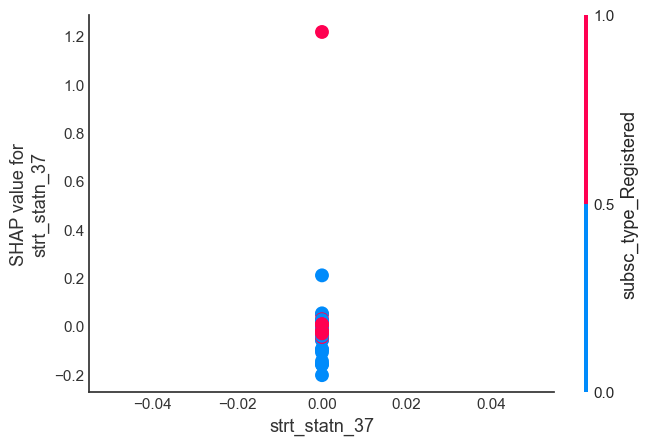

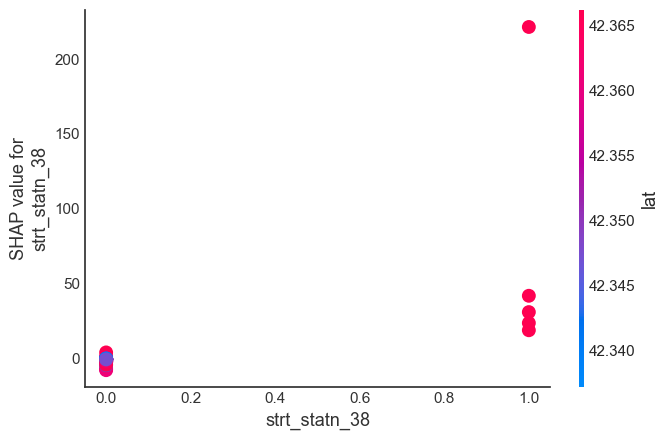

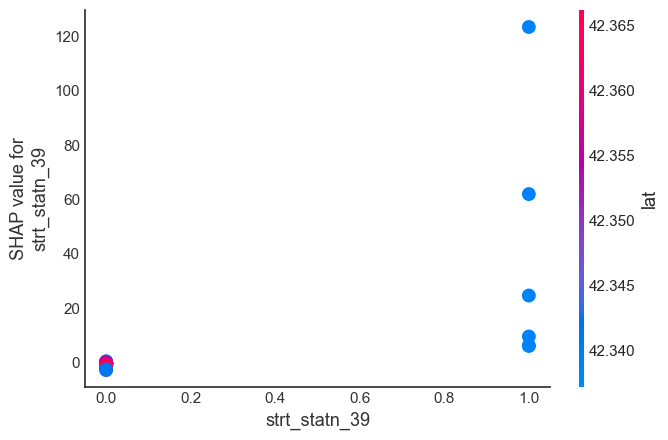

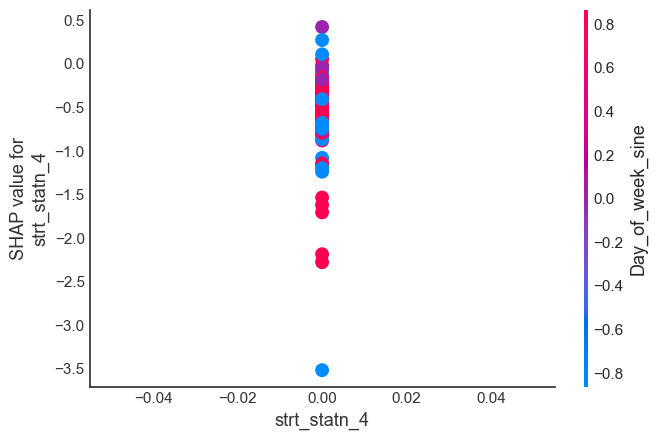

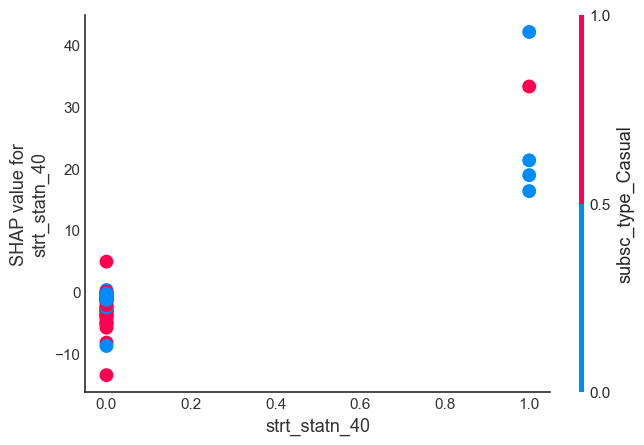

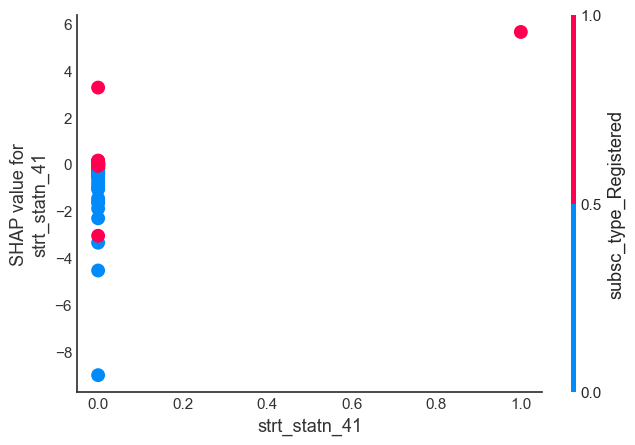

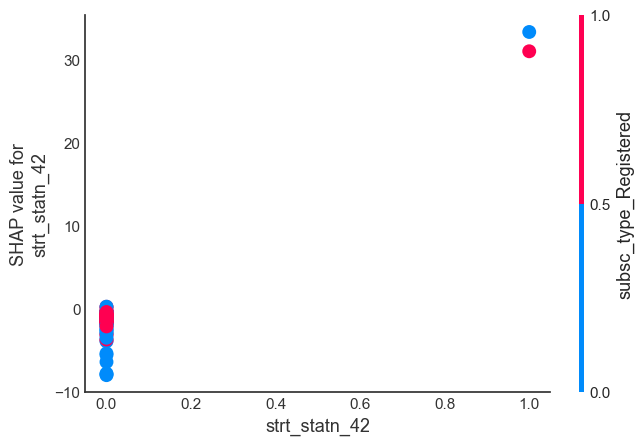

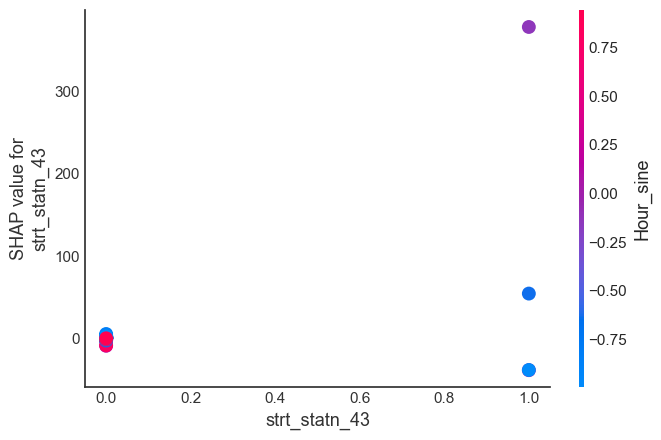

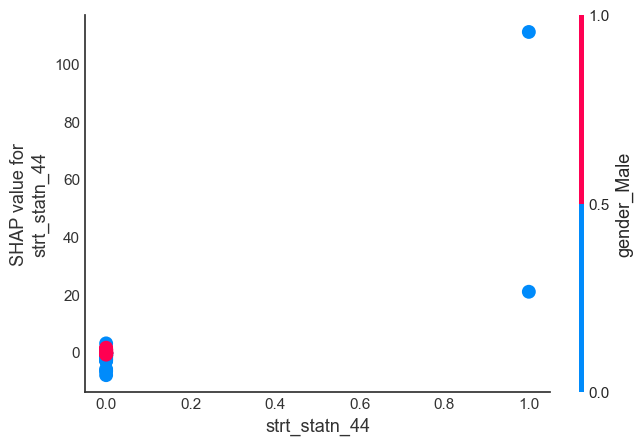

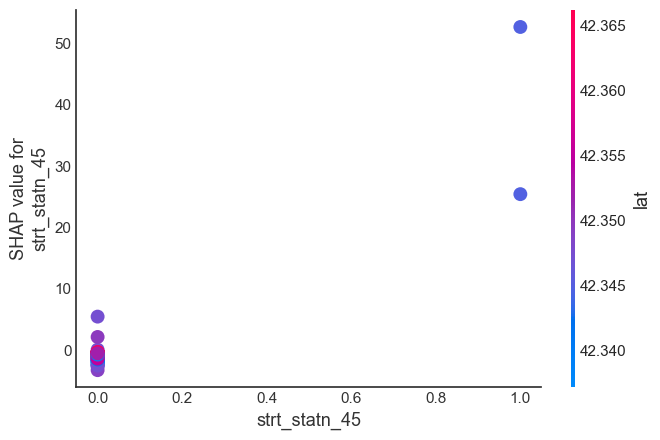

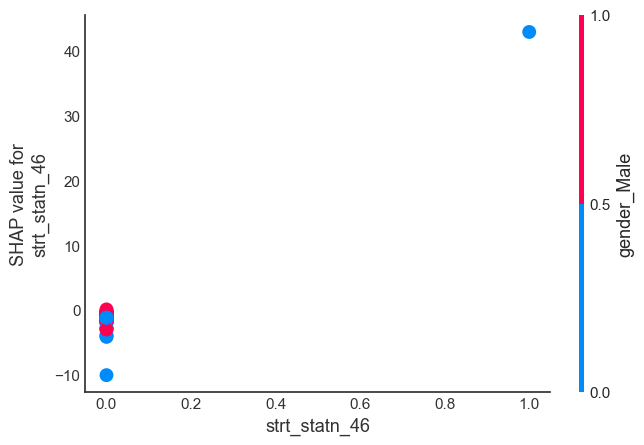

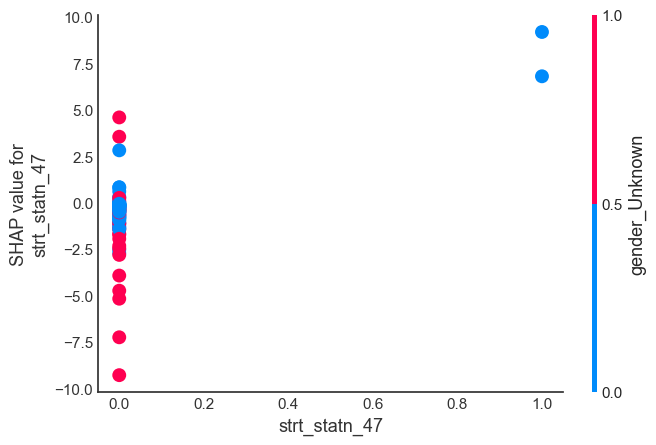

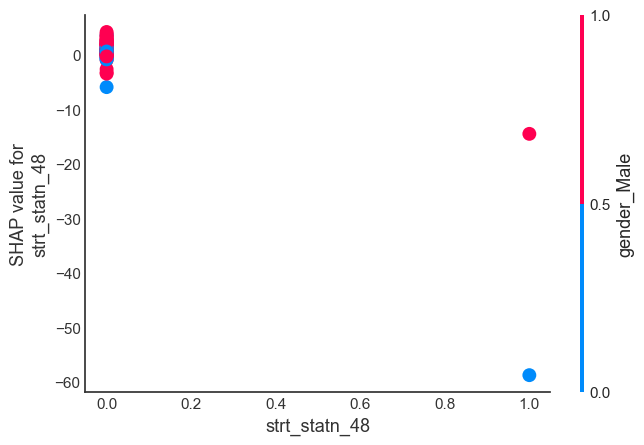

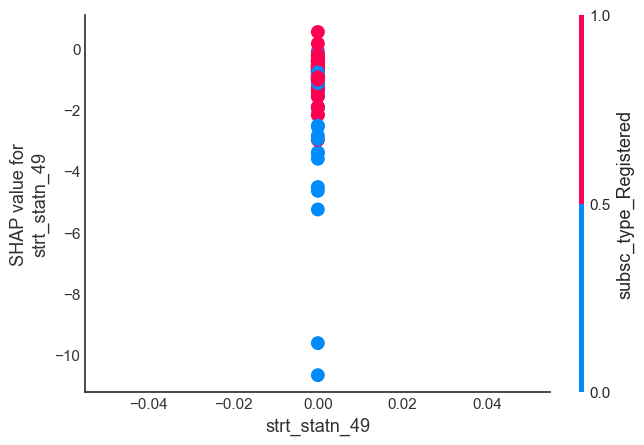

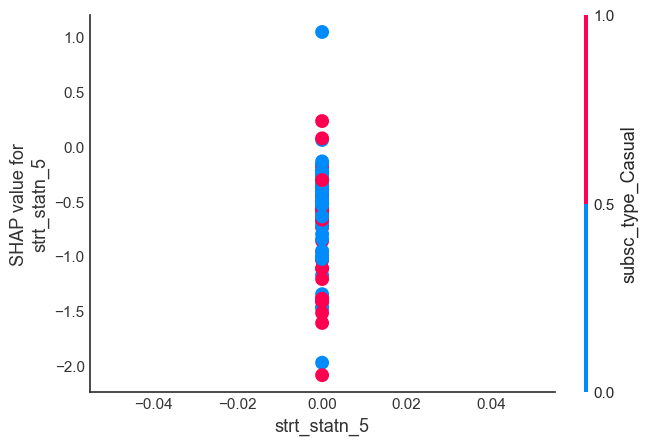

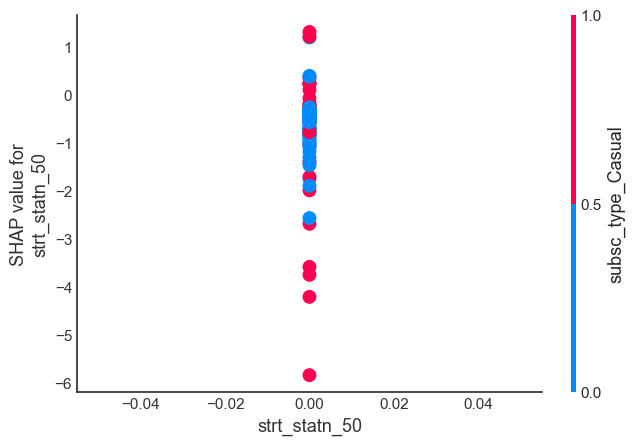

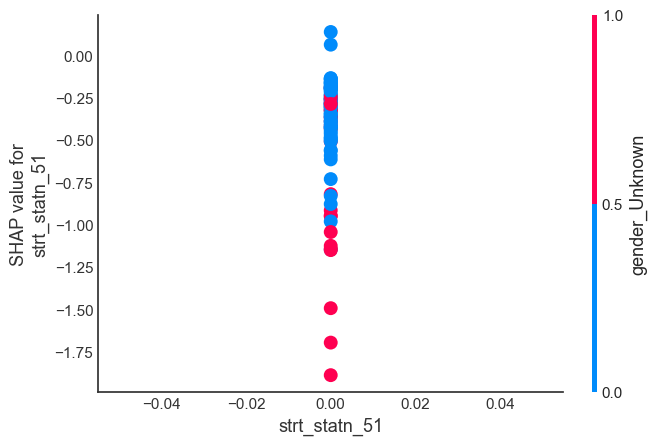

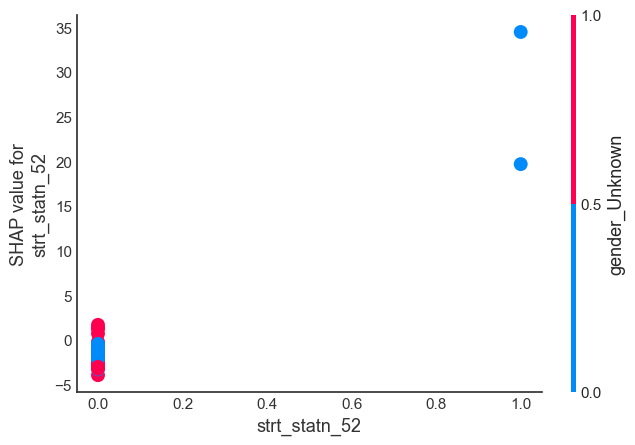

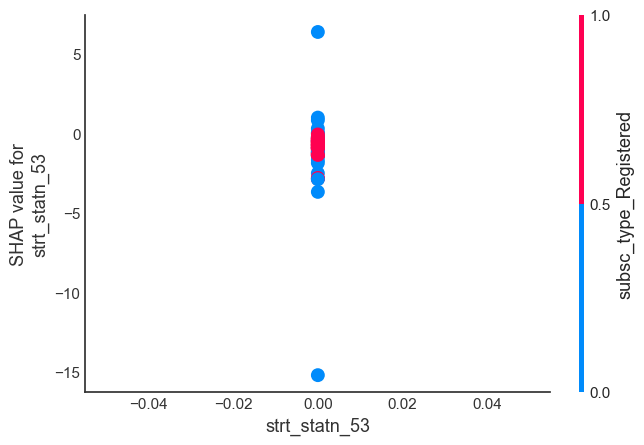

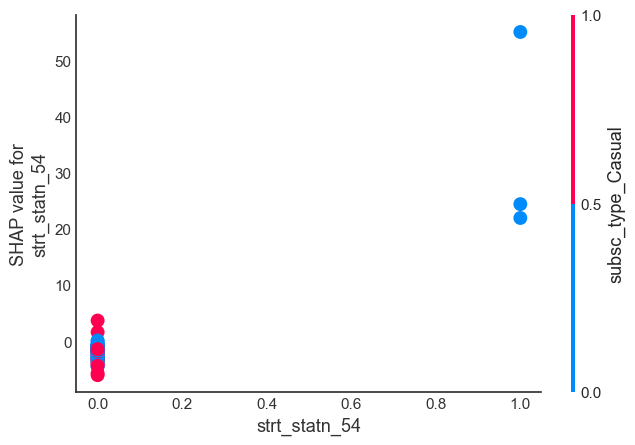

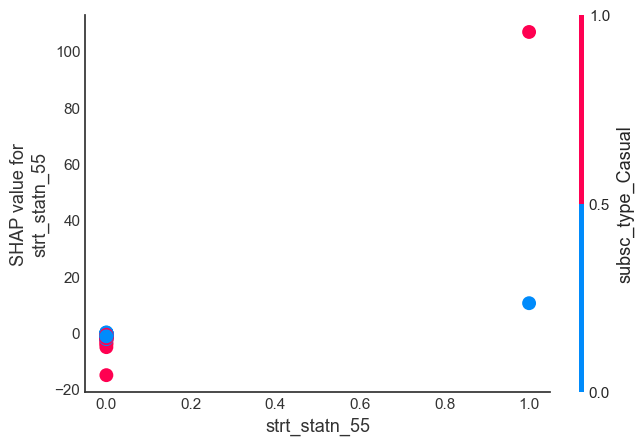

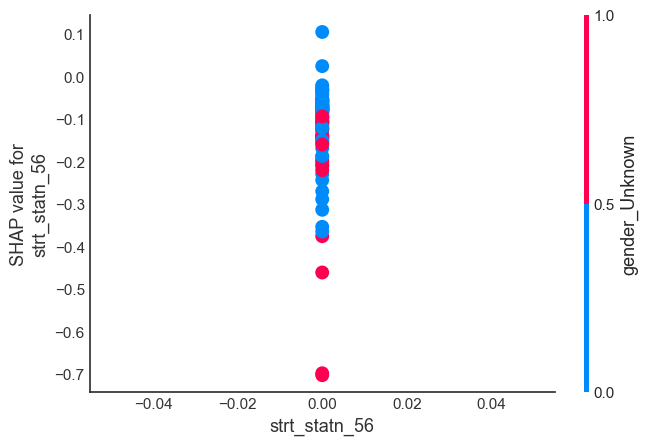

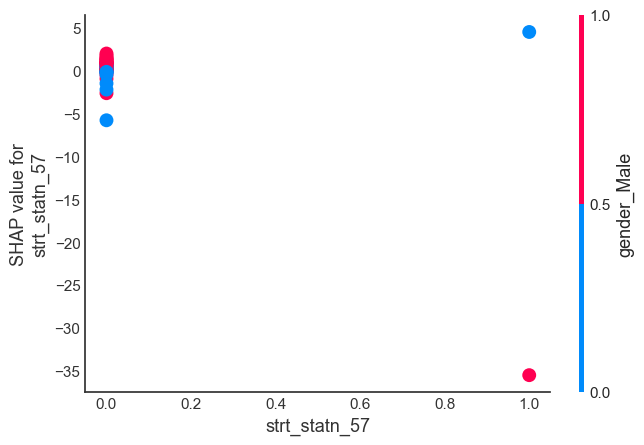

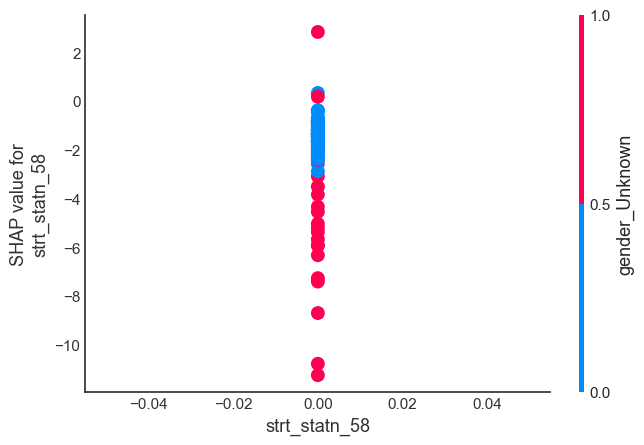

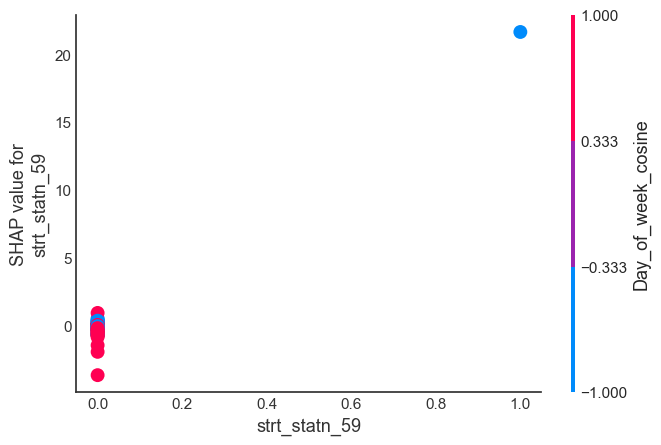

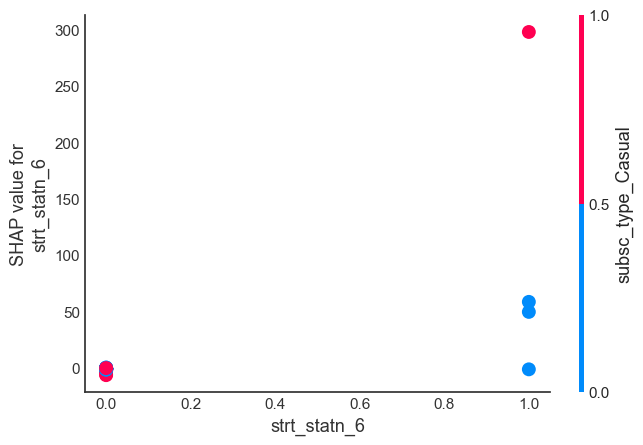

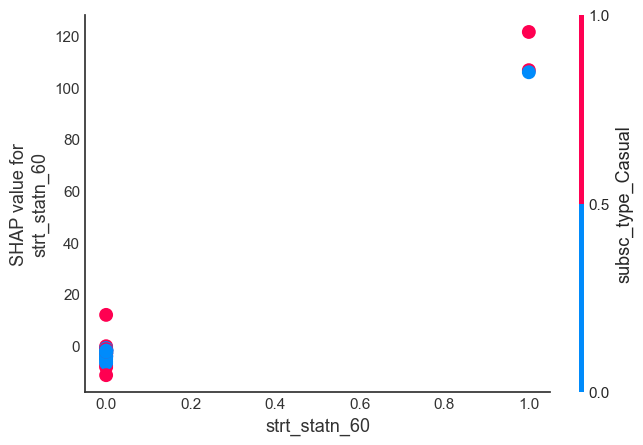

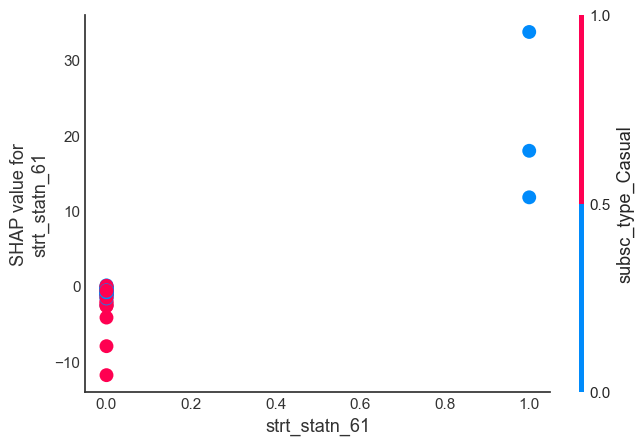

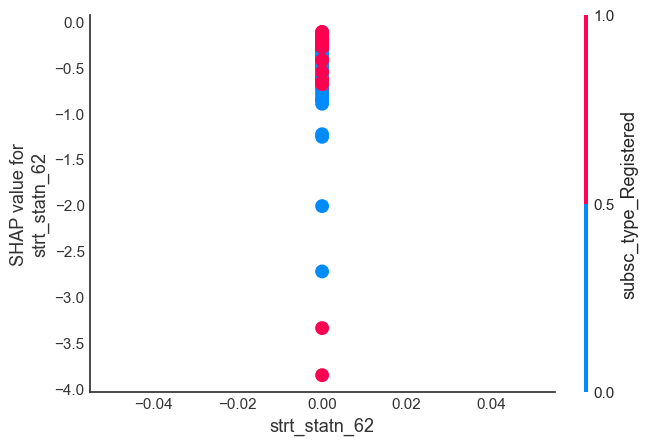

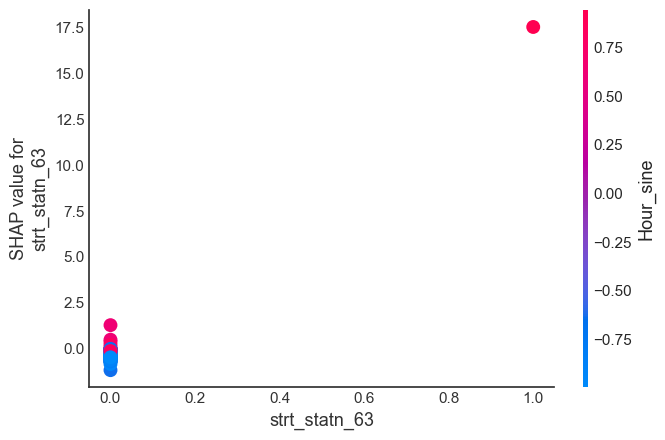

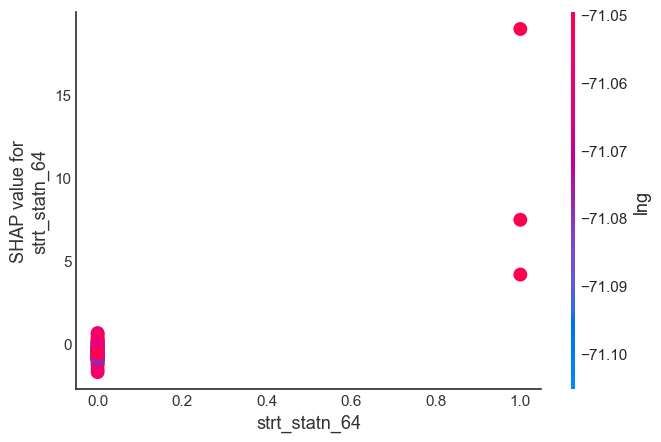

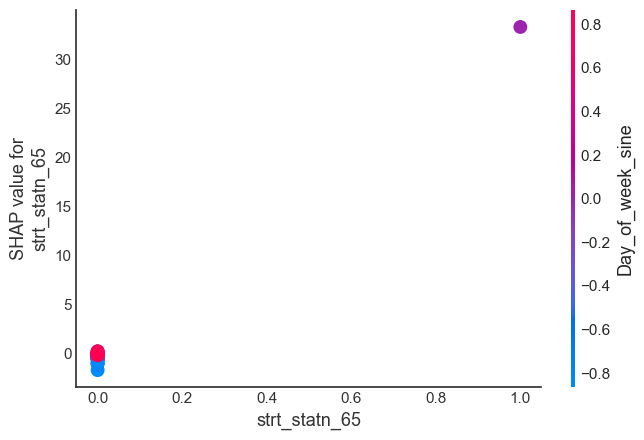

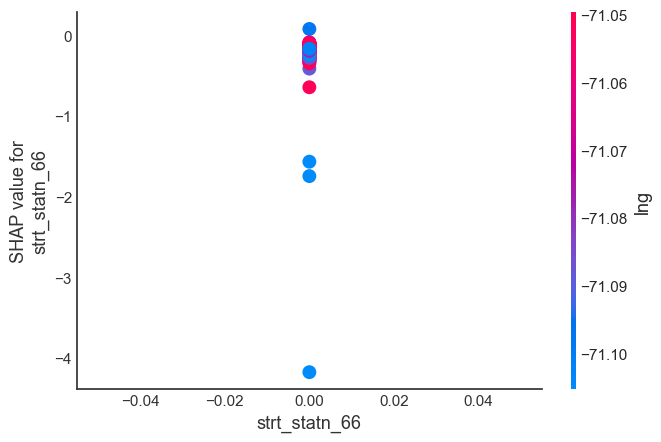

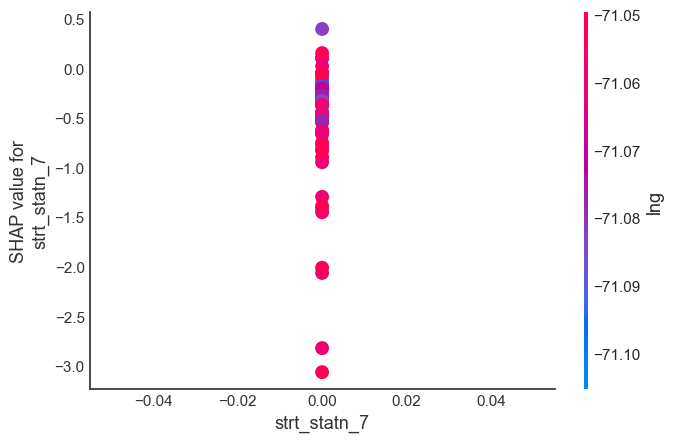

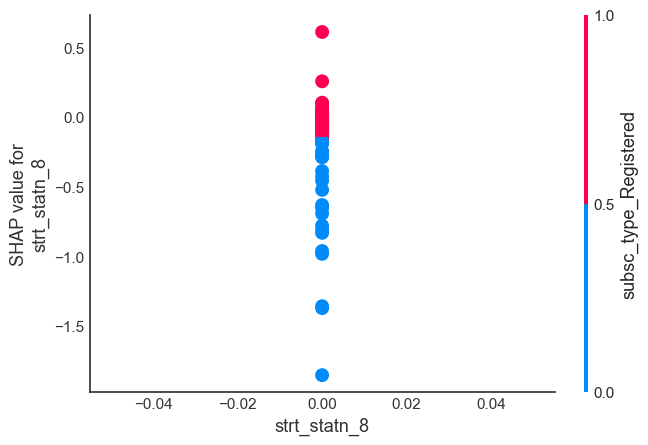

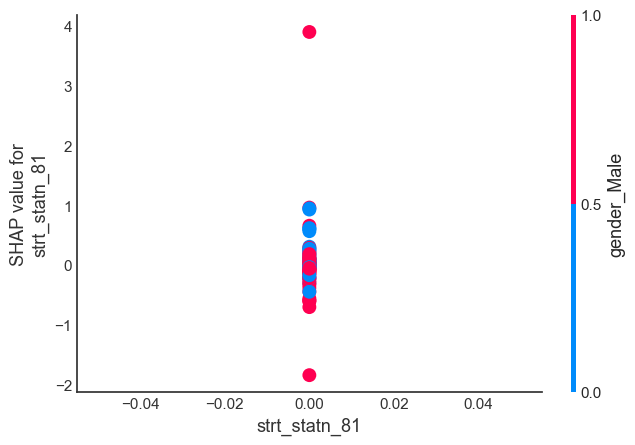

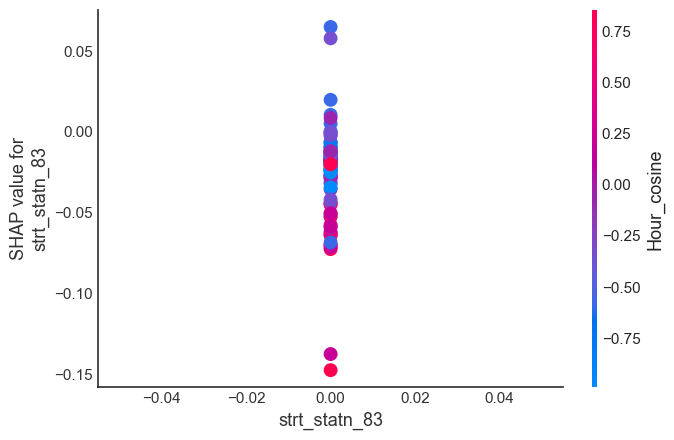

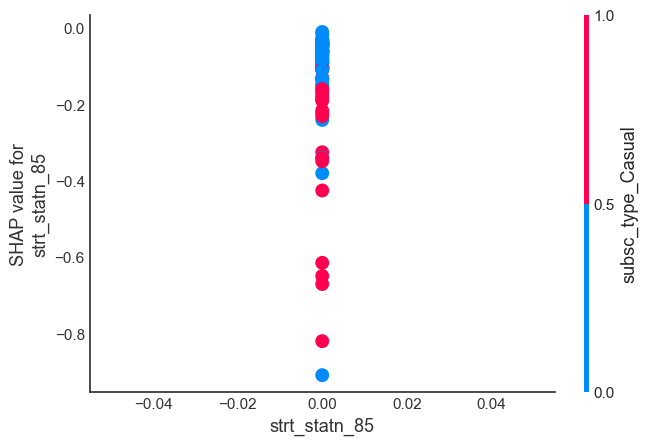

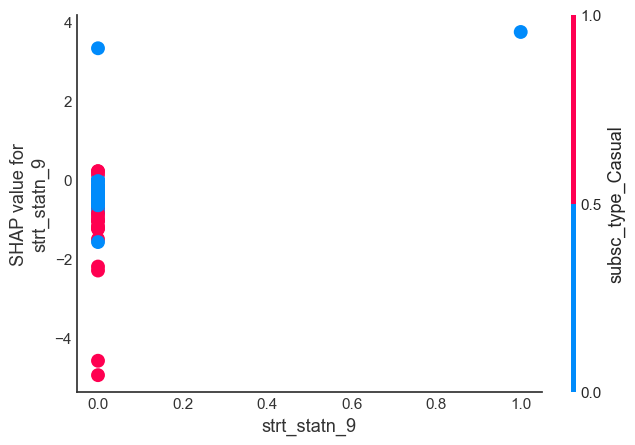

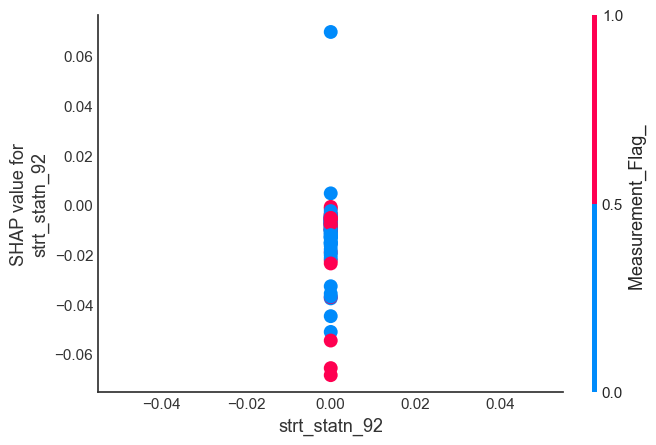

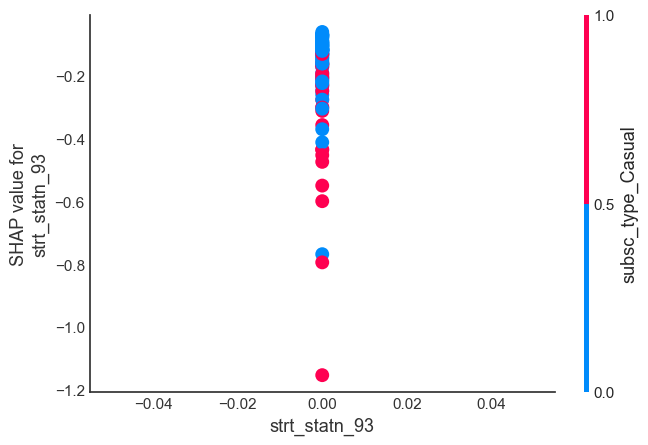

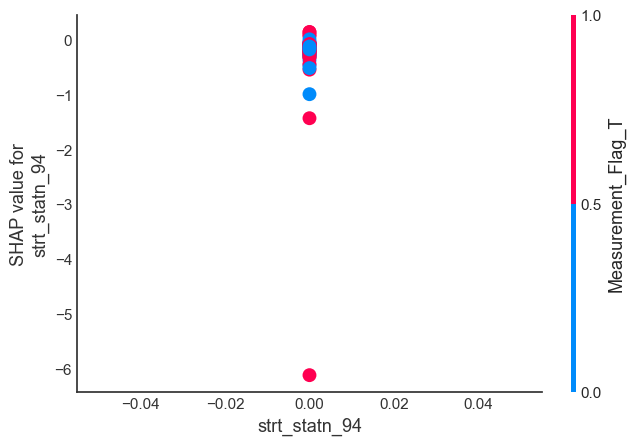

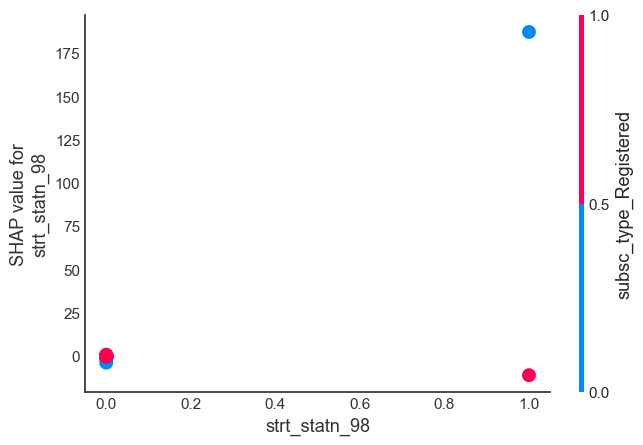

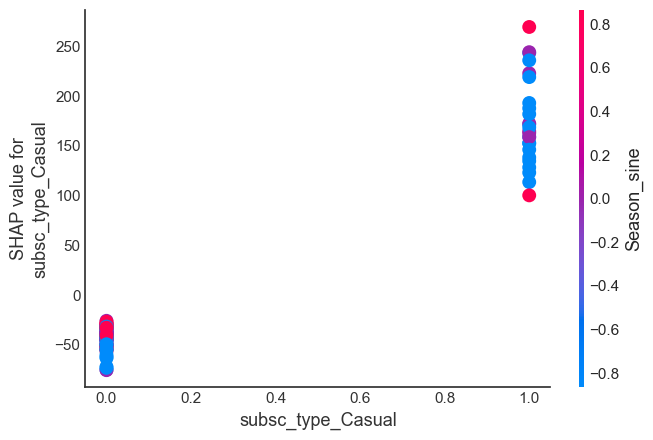

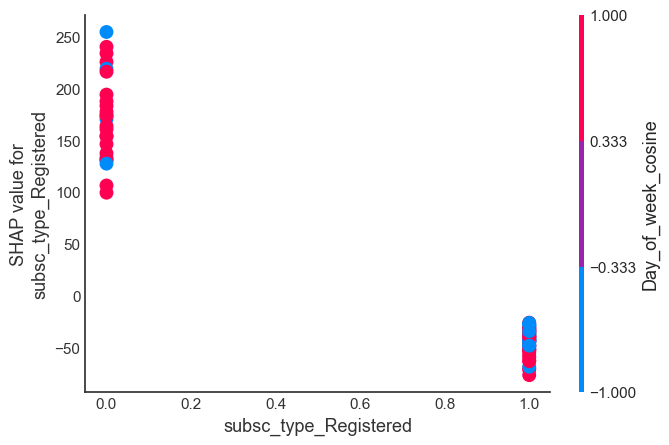

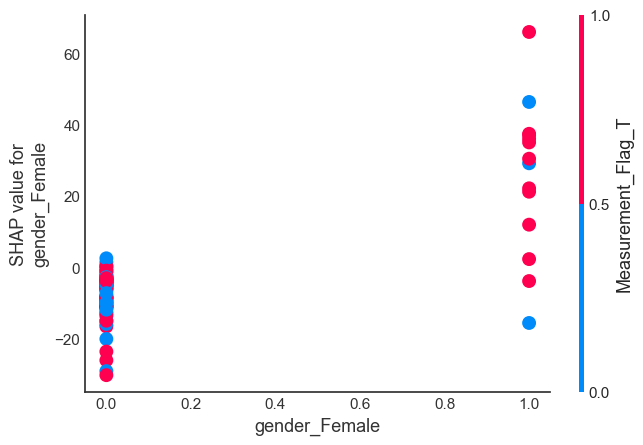

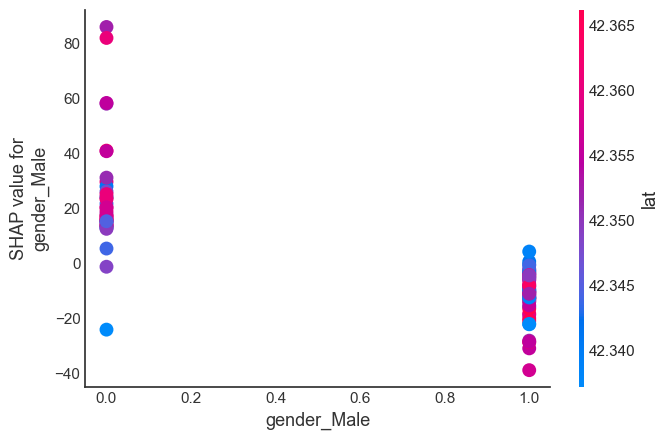

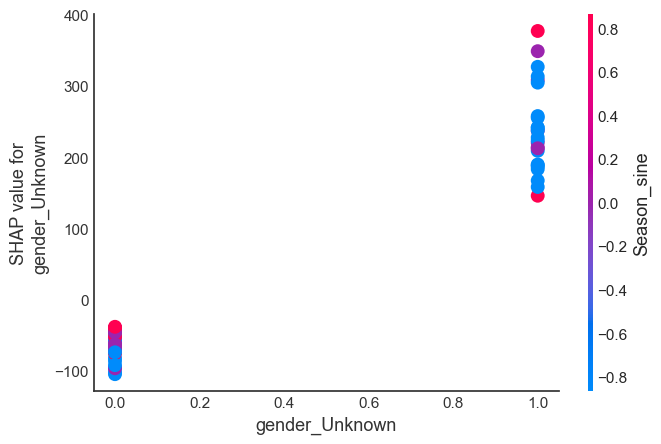

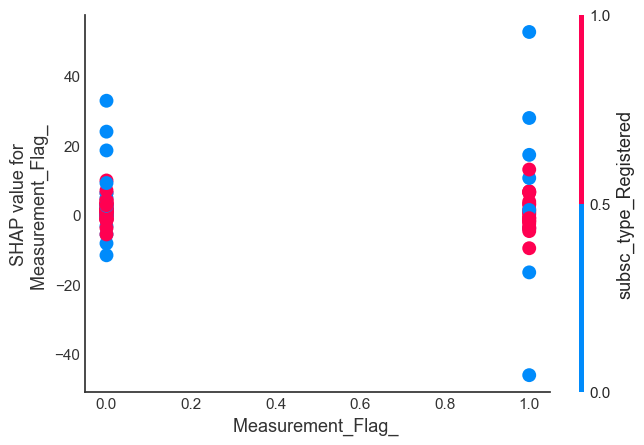

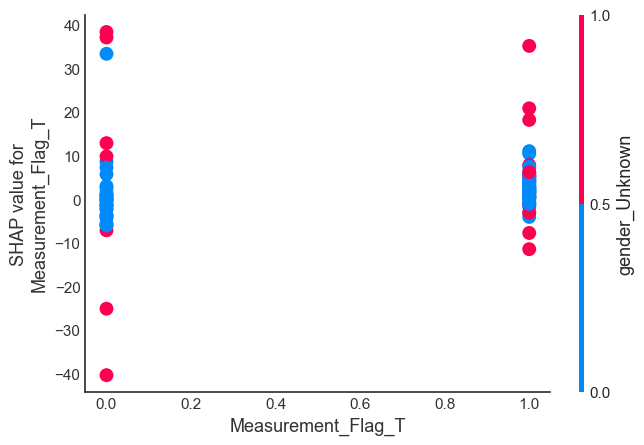

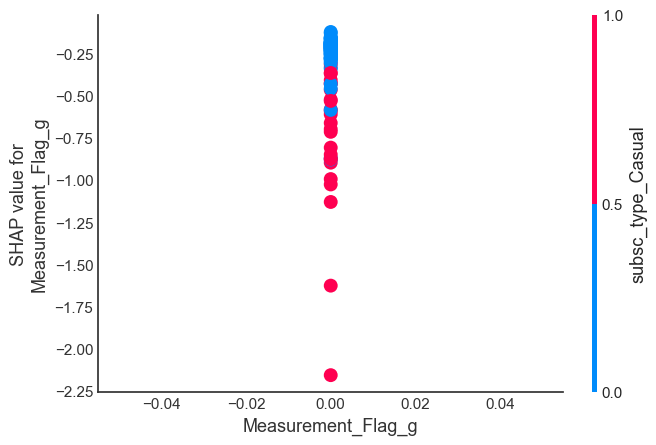

In [79]:
for feat in features:
    shap.dependence_plot(feat, test_shap_vals, X_test[0:100], 
                         dot_size=100)

# Conclusions

We have modeld the problem using Random forest regressor which had an RMSE of 542.12 and it performed better than Gradient boosting. 
